In [1]:
from constants import *
from utils import *
from modules import *

In [2]:
import random
import time
from collections import Counter
from collections import defaultdict
%matplotlib inline
random.seed(2019)

In [3]:
model_id = 'larn'

## Input

In [4]:
bmap, cmap, wmap, revmap, span_data, span_size, target_pred_ix_set, We = load_data(data_load_path)

num_chars, num_books, num_traj = len(cmap), len(bmap), len(span_data)

In [5]:
descriptor_log = 'descriptors_model_' + str(model_id) + '.log'

trajectory_log = 'trajectories_model_' + str(model_id) + '.log'

desc_sample_file_name = 'desc_selected_sample_dict_model_' + str(model_id) + '.pkl'

attn_sample_file_name = 'attn_selected_sample_dict_model_' + str(model_id) + '.pkl'

training_progress_log = 'training_progress_log_' + str(model_id) + '.txt'

model_object_file_name = 'trained_model_' + str(model_id) + '.pt'

A_dict_file_name = 'A_dict_' + str(model_id) + '.pkl'

## Model

In [6]:
class LARN(nn.Module):

    def __init__(self, d_word, d_noun_hidden, d_ent, d_meta, d_mix, d_desc, n_ent, n_meta, We):
        super(LARN, self).__init__()
        self.d_desc = d_desc
        tensor_We = torch.FloatTensor(We).to(device)
        self.l_st = TrainedWordEmbeddingLayer(tensor_We, d_word)
        self.l_noun = NounAttentionLayer_SingleQuery(tensor_We, d_word, d_noun_hidden, d_desc)
        self.l_ent = nn.Embedding(n_ent, d_ent)
        self.l_mix = MixingLayer_Attention_SingleQuery_Concat(d_word, d_noun_hidden, d_ent, d_mix)
        self.l_rels = DistributionLayer(d_mix, d_desc)
        self.l_recon = nn.Linear(d_desc, d_word)
        nn.init.xavier_uniform_(self.l_recon.weight)
        
    def init_attention(self, A):
        self.l_noun.query.weight = nn.Parameter(A)

    def forward(self, spans, noun_spans, e1, e2, months):
        e1_tensor = torch.LongTensor(e1).to(device)
        e2_tensor = torch.LongTensor(e2).to(device)
        
        outputs_l_st = self.l_st(spans)
        outputs_l_noun = self.l_noun(noun_spans, months)
        outputs_l_e1 = self.l_ent(e1_tensor).expand(len(spans), -1)
        outputs_l_e2 = self.l_ent(e2_tensor).expand(len(spans), -1)
        
        outputs_l_mix = self.l_mix(outputs_l_st, outputs_l_noun, outputs_l_e1, outputs_l_e2)
        
        outputs_l_rels = self.l_rels(outputs_l_mix)
        
        outputs = self.l_recon(outputs_l_rels)
        return outputs, outputs_l_rels

## Training

In [ ]:
model = LARN(d_word, d_noun_hidden, d_char, d_book, d_mix, num_descs, num_chars, num_books, We).to(device)
loss_function = Contrastive_Max_Margin_Loss().to(device)
optimizer = optim.Adam(filter(lambda x: x.requires_grad, model.parameters()), lr=lr)
label_generation_layer = TrainedWordEmbeddingLayer(torch.FloatTensor(We), d_word).to(device)

A_dict = dict()

for epoch in range(n_epochs):
    epoch_start_t = time.time()
    epoch_total_loss = torch.tensor(0.).to(device)
    random.shuffle(span_data)
    
    for book, chars, big_spans, big_masks, big_months, _ in span_data:
        char1 = [chars[0]]
        char2 = [chars[1]]
        
        zip_list_to_shuffle = list(zip(big_spans, big_masks, big_months))
        random.shuffle(zip_list_to_shuffle)
        shuffled_big_spans, shuffled_big_masks, shuffled_big_months = zip(*zip_list_to_shuffle)
        
        split_indices = [i for i in range(0, len(shuffled_big_spans), batch_size)] # split to batches to fit in memory
        spans_split = np.split(shuffled_big_spans, split_indices)
        masks_split = np.split(shuffled_big_masks, split_indices)
        months_split = np.split(shuffled_big_months, split_indices)
        
        for spans, masks, months in zip(spans_split, masks_split, months_split):
            if len(spans) != batch_size:
                continue
        
            model.zero_grad()

            if (chars[0], chars[1]) in A_dict:
                model.init_attention(A_dict[(chars[0], chars[1])].to(device))
            else:
                nn.init.xavier_uniform_(model.l_noun.query.weight)

            train_masked_spans = []
            noun_spans = []
            drop_masks = (np.random.rand(*(masks.shape)) < (1 - p_drop)).astype('float32')
            for span_index, (span, mask, drop_mask) in enumerate(zip(spans, masks, drop_masks)):
                train_masked_span = [span[i] for i in range(len(span))
                                     if mask[i] == predicate_ix and drop_mask[i] == 1]
                train_masked_spans.append(train_masked_span)
                noun_span = [span[i] for i in range(len(span)) if mask[i] == noun_ix]
                noun_spans.append(noun_span)

            pos_masked_spans = []
            for span_index, (span, mask) in enumerate(zip(spans, masks)):
                pos_masked_span = [span[i] for i in range(len(span)) if mask[i] == predicate_ix]
                pos_masked_spans.append(pos_masked_span)

            neg_spans, neg_masks = generate_negative_samples(num_traj, span_size,
                                                             num_negs, span_data)
            neg_masked_spans = []
            for span_index, (span, mask) in enumerate(zip(neg_spans, neg_masks)):
                neg_masked_span = [span[i] for i in range(len(span)) if mask[i] == predicate_ix]
                neg_masked_spans.append(neg_masked_span)

            outputs, _outputs_l_rels = model(train_masked_spans, noun_spans, char1, char2, months)
            pos_labels = label_generation_layer(pos_masked_spans)
            neg_labels = label_generation_layer(neg_masked_spans)

            R = torch.t(model.l_recon.weight)

            loss = loss_function(outputs, pos_labels, neg_labels, len(spans), R, eps, d_word)

            loss.backward()
            optimizer.step()
            epoch_total_loss += loss

            A = model.l_noun.query.weight.detach().cpu()
            A_dict[(chars[0], chars[1])] = A
    
    print("epoch %d finished in %.2f seconds" % (epoch, (time.time() - epoch_start_t)))
    print(epoch_total_loss)
    f_tpl = open(training_progress_log, 'a')
    f_tpl.write('epoch ' + str(epoch) + ': ' + str(time.time() - epoch_start_t) + '\n')
    f_tpl.close()

In [ ]:
torch.save(model, model_object_file_name)

In [ ]:
pickle.dump(A_dict, open(A_dict_file_name, 'wb'))

## Trained Model

In [10]:
model = torch.load(model_object_file_name)

In [11]:
A_dict = pickle.load(open(A_dict_file_name, 'rb'))

## Descriptor Generation

In [12]:
target_word_ix_set = set()
target_word_ix_counter = Counter()

for _, _, spans, masks, _ , _ in span_data:
    for span, mask in zip(spans, masks):
        for w, m in zip(span, mask):
            if m == predicate_ix:
                target_word_ix_counter[w] += 1
                
for wix, _ in target_word_ix_counter.most_common()[:500]: # can also do without this 500 top word limit
    target_word_ix_set.add(wix)

In [13]:
log = open(descriptor_log, 'w')

R = torch.t(model.l_recon.weight).detach().cpu().numpy()
for ind in range(len(R)):
    desc = R[ind] / np.linalg.norm(R[ind])
    top_desc_list = []
    
    sims = We.dot(np.transpose(desc))
    ordered_words = np.argsort(sims)[::-1]

    desc_list = []
    num_satisfied = 0
    for w in ordered_words:
        if num_satisfied >= num_descs_choice:
            break
        if w in target_word_ix_set:
            desc_list.append(revmap[w])
            num_satisfied += 1
    
    sentiment_score = calc_desc_sentiment(desc_list)
    top_desc_list.append('-'.join(desc_list) + ' [' + str(sentiment_score) + ']')

    print('descriptor %d:' % ind)
    print(top_desc_list)
    print()

    log.write(' '.join(top_desc_list) + '\n')
log.flush()
log.close()

descriptor 0:
['launch-announce-unveil-release-celebrate [0.5719]']

descriptor 1:
['win-defeat-beat-title-match [0.2023]']

descriptor 2:
['offer-provide-deliver-feature-guarantee [0.25]']

descriptor 3:
['discuss-reiterate-examine-quote-explain [0.0]']

descriptor 4:
['import-export-file-fix-limit [0.0]']

descriptor 5:
['receive-express-praise-send-acknowledge [0.5574]']

descriptor 6:
['play-enjoy-hack-watch-miss [0.6124]']

descriptor 7:
['raise-increase-reduce-generate-encourage [0.6808]']

descriptor 8:
['purchase-sell-pay-buy-cost [-0.1027]']

descriptor 9:
['strengthen-enhance-improve-develop-boost [0.7845]']

descriptor 10:
['survey-study-examine-assess-report [0.0]']

descriptor 11:
['announce-attend-oversee-appoint-undertake [0.0]']

descriptor 12:
['differ-indicate-affect-regard-determine [0.0]']

descriptor 13:
['include-comprise-feature-contain-involve [0.0]']

descriptor 14:
['produce-bring-sell-convey-represent [0.0]']

descriptor 15:
['face-display-confront-reveal-hig

## Temporal Trend Generation

In [14]:
sample_dict = defaultdict(dict)
desc_dist_dict = dict()

tlog = open(trajectory_log, 'w')
traj_writer = csv.writer(tlog)
traj_writer.writerow(['Book', 'Char 1', 'Char 2', 'Span ID'] + ['Topic ' + str(i) for i in range(num_descs)])

with torch.no_grad():
    for book, chars, spans, masks, months, samples in span_data:
        c1_name, c2_name = [cmap[c] for c in chars]
        b_name = bmap[book[0]]
        rel = c1_name + ' AND ' + c2_name
        
        if rel not in interest_pairs:
            continue

        sample_dict[b_name][c1_name+' AND '+c2_name] = dict()
        for span_index, sample in enumerate(samples):
            sample_dict[b_name][c1_name+' AND '+c2_name][span_index] = sample

        char1 = [chars[0]]
        char2 = [chars[1]]
        model.zero_grad()
        model.init_attention(A_dict[(chars[0], chars[1])].to(device))

        masked_spans = []
        noun_spans = []
        for span_index, (span, mask) in enumerate(zip(spans, masks)):
            masked_span = [span[i] for i in range(len(span)) if mask[i] == predicate_ix]
            masked_spans.append(masked_span)
            noun_span = [span[i] for i in range(len(span)) if mask[i] == noun_ix]
            noun_spans.append(noun_span)

        # rerun input through model
        _outputs, outputs_l_rels = model(masked_spans, noun_spans, char1, char2, months)
        
        # save descriptor distribution data
        desc_dist_dict[rel] = dict()
        for span_index, olr in enumerate(outputs_l_rels.detach().cpu().numpy()):
            traj_writer.writerow([b_name, c1_name, c2_name, months[span_index], span_index] + [o for o in olr])
            desc_dist_dict[rel][span_index] = olr

In [15]:
vis_dict = dict() # for visualization
num_nouns_choice = 10
num_top_descs = 3 # to get an overview for all descriptors, change this to 30

In [16]:
desc_selected_sample_dict = defaultdict(dict) # key: (int_desc_index, int_month_info)
major_desc_sum_dict = defaultdict(float)

rmn_traj = read_csv(trajectory_log)
rmn_descs = read_descriptors(descriptor_log)

for book in rmn_traj:
    for rel in rmn_traj[book]:
        if rel not in interest_pairs:
            continue
            
        desc_selected_sample_dict[book][rel] = defaultdict(list)
        plt.close()
        
        rtraj = rmn_traj[book][rel]['distributions']
        mtraj = rmn_traj[book][rel]['months']
        itraj = rmn_traj[book][rel]['span_index']
        
        data_d = dict()
        desc_sum_d = defaultdict(float)
        trivial_descs = set()
        
        # find non-trivial descs
        for i in range(num_descs):
            data_d[i] = defaultdict(list)
        for r, m in zip(rtraj, mtraj):
            for i, desc in enumerate(r):
                data_d[i][m].append(desc)
        for i in data_d.keys():
            trivial = True
            for m in data_d[i].keys():
                desc_sum_d[i] += np.mean(data_d[i][m])

        top_ds = [top_d[0] for top_d in sorted([(i, share) for i, share in desc_sum_d.items()],
                                               key=lambda x: -x[1])[:num_top_descs]] # get top three descriptors
        
        # to get which relation to use in attended word heatmap
        print(rel)
        print(rmn_descs[top_ds[0]], rmn_descs[top_ds[1]], rmn_descs[top_ds[2]])
        
        seaborn_d = {'month_info': [], 'desc_share': [], 'desc_type': []}
        desc_share_dict = defaultdict(list)
        
        for r, m, span_index in zip(rtraj, mtraj, itraj):
            for i, desc in enumerate(r):
                if i not in top_ds:
                    continue
                desc_share_dict[(i, m)].append((desc, span_index))
                seaborn_d['month_info'].append('20' + month_to_str(m, year_base))
                seaborn_d['desc_share'].append(desc)
                seaborn_d['desc_type'].append(i)
                major_desc_sum_dict[i] += desc
                
        for k in desc_share_dict.keys():
            desc_share_dict[k].sort(key=lambda x: -x[0])
            if len(desc_share_dict[k]) < sample_sel_num:
                continue
            for sel_i in range(sample_sel_num):
                desc_selected_sample_dict[book][rel][k].append(sample_dict[book][rel][desc_share_dict[k][sel_i][1]])
        
        vis_dict[rel] = [seaborn_d]

pickle.dump(desc_selected_sample_dict, open(desc_sample_file_name, 'wb'))

U.S. AND U.K.
leave-tell-ask-know-want, [0.0258] denounce-undermine-condemn-punish-oppose, [-0.8625] differ-indicate-affect-regard-determine, [0.0]
U.S. AND Canada
include-comprise-feature-contain-involve, [0.0] leave-tell-ask-know-want, [0.0258] denounce-undermine-condemn-punish-oppose, [-0.8625]
U.S. AND Russia
denounce-undermine-condemn-punish-oppose, [-0.8625] differ-indicate-affect-regard-determine, [0.0] leave-tell-ask-know-want, [0.0258]
U.S. AND Syria
denounce-undermine-condemn-punish-oppose, [-0.8625] leave-tell-ask-know-want, [0.0258] target-attack-bomb-kill-intercept, [-0.9001]
U.S. AND China
denounce-undermine-condemn-punish-oppose, [-0.8625] strengthen-enhance-improve-develop-boost, [0.7845] leave-tell-ask-know-want, [0.0258]
China AND India
strengthen-enhance-improve-develop-boost, [0.7845] leave-tell-ask-know-want, [0.0258] differ-indicate-affect-regard-determine, [0.0]
U.S. AND India
leave-tell-ask-know-want, [0.0258] denounce-undermine-condemn-punish-oppose, [-0.8625] 

## Attended Words Generation

In [17]:
attn_selected_sample_dict = defaultdict(dict) # key: (int_desc_index, int_month_info): (word)

with torch.no_grad():
    for book, chars, spans, masks, months, samples in span_data:
        c1_name, c2_name = [cmap[c] for c in chars]
        b_name = bmap[book[0]]
        rel = c1_name + ' AND ' + c2_name
        
        if rel not in interest_pairs:
            continue
            
        char1 = [chars[0]]
        char2 = [chars[1]]
        model.zero_grad()
        model.init_attention(A_dict[(chars[0], chars[1])].to(device))
        
        # starting attention calculation
        attn_seaborn_d = dict()
        attn_score_dict = defaultdict(dict) # structure: (desc_i, month_i): (attended word): [(score, span_index)]
        attn_selected_sample_dict[b_name][rel] = defaultdict(dict)
        
        base_seaborn_d = dict()
        base_count_dict = defaultdict(dict) # structure: (desc_i, month_i): (word): (word count)
        overall_base_count_dict = dict()
        
        # calculate attention score for each document
        for span_index, (span, mask, month) in enumerate(zip(spans, masks, months)):
            prom_i = np.argmax(desc_dist_dict[rel][span_index]) # give attention record to the prominent descriptor
            
            candidate_set = set()
            for i in range(len(span)):
                if mask[i] == noun_ix:
                    candidate_set.add((span[i], month))
                    if revmap[span[i]] not in base_count_dict[(prom_i, month)].keys():
                        base_count_dict[(prom_i, month)][revmap[span[i]]] = 1
                    else:
                        base_count_dict[(prom_i, month)][revmap[span[i]]] += 1
                    if prom_i not in overall_base_count_dict:
                        overall_base_count_dict[prom_i] = defaultdict(int)
                    overall_base_count_dict[prom_i][revmap[span[i]]] += 1

            if len(candidate_set) == 0:
                continue

            noun_list = []
            month_list = []
            for candidate in candidate_set:
                noun_list.append(candidate[0])
                month_list.append(candidate[1])

            noun_part_mat = model.l_noun.we(torch.LongTensor(noun_list).to(device))
            month_part_mat = torch.zeros([len(noun_part_mat), d_noun_hidden - d_word], dtype=torch.float).to(device)
            for i, month in enumerate(month_list):
                month_part_mat[i][month] = 1

            hidden_mat = torch.cat((noun_part_mat, month_part_mat), 1)

            key_mat = model.l_noun.linear_key(hidden_mat)
            key_mat = torch.tanh(key_mat)

            query_mat = model.l_noun.query(torch.LongTensor([i for i in range(1)]).to(device)) # only one q_vec

            alpha_mat = torch.mm(query_mat, torch.t(key_mat))
            alpha_mat = F.softmax(alpha_mat, dim=1)
            alpha_mat = alpha_mat.detach().cpu().numpy()
            
            alpha_row = alpha_mat[0] # only one q_vec

            for j, score in enumerate(alpha_row):
                if revmap[noun_list[j]] in attn_score_dict[(prom_i, month)].keys():
                    attn_score_dict[(prom_i, month)][revmap[noun_list[j]]].append((score, span_index))
                else:
                    attn_score_dict[(prom_i, month)][revmap[noun_list[j]]] = [(score, span_index)]
                    
        # rebuild the alpha mat for back compatibility
        noun_list = []
        month_list = []
        noun_month_set = set()
        for desc_i, month_i in attn_score_dict.keys():
            for attn_word in attn_score_dict[(desc_i, month_i)].keys():
                # START - A fix for previous bug of duplicate (noun, month) pair in alpha_mat
                if (attn_word, month_i) in noun_month_set:
                    continue
                else:
                    noun_month_set.add((attn_word, month_i))
                # - END
                noun_list.append(attn_word)
                month_list.append(month_i)
        alpha_mat = np.zeros([num_descs, len(noun_list)])
        for i in range(num_descs):
            for j, (noun, month_i) in enumerate(zip(noun_list, month_list)):
                if noun not in attn_score_dict[(i, month_i)]:
                    continue
                _scores = [score for score, span_index in attn_score_dict[(i, month_i)][noun]]
                alpha_mat[i][j] = np.mean(_scores) * np.log(len(_scores)) # attention score definition
                
        # original processing for common and special attended words
        for i, row in enumerate(alpha_mat):
            attn_seaborn_d[i] = {'month_info': [], 'attn_score': [], 'attn_word': []}

            all_nouns = defaultdict(list)
            # overall_score_dict = defaultdict(float)
            overall_score_dict = defaultdict(list)

            for j in np.argsort(row)[::-1]:
                month_str = month_to_str(month_list[j], year_base)
                all_nouns[month_str].append((noun_list[j], row[j]))
                # overall_score_dict[noun_list[j]] += row[j]
                overall_score_dict[noun_list[j]].append(row[j])

            keyword_list = []

            # add overall highest scored word to keyword list
            # for w, score in sorted(list(overall_score_dict.items()), key=lambda x: -x[1])[:num_nouns_choice]:
            for w, score in sorted(list(overall_score_dict.items()), key=lambda x: -np.sum(x[1]))[:num_nouns_choice]:
                keyword_list.append(w)

            # build seaborn dict
            for m in sorted([str_m for str_m in all_nouns.keys()],
                            key=lambda x: int(x[:2]) * 12 + int(x[-2:]) if len(x) == 5
                            else int(x[:2]) * 12 + int(x[-1:])):
                for w in keyword_list:
                    target_score = 0
                    for tw, tscore in all_nouns[m]:
                        if tw == w:
                            target_score = tscore
                            break
                    attn_seaborn_d[i]['month_info'].append(m)
                    attn_seaborn_d[i]['attn_score'].append(target_score)
                    attn_seaborn_d[i]['attn_word'].append(w)
                    if w not in attn_score_dict[(i, str_to_month(m, year_base))].keys():
                        continue
                    w_sample_indices = [span_index for score, span_index in sorted(
                        attn_score_dict[(i, str_to_month(m, year_base))][w], key=lambda x: -x[0])]
                    if len(w_sample_indices) < sample_sel_num:
                        continue
                    attn_selected_sample_dict[b_name][rel][(i, str_to_month(m, year_base))][w]\
                        = [sample_dict[b_name][rel][ind] for ind in w_sample_indices[:sample_sel_num]]

            attn_seaborn_d[i]['keyword_list'] = keyword_list
            attn_seaborn_d[i]['month_list'] = [m for m in sorted([str_m for str_m in all_nouns.keys()],
                            key=lambda x: int(x[:2]) * 12 + int(x[-2:]) if len(x) == 5
                            else int(x[:2]) * 12 + int(x[-1:]))]
            
            # generate baseline's dictionary for seaborn figure
            base_seaborn_d[i] = {'month_info': [], 'base_score': [], 'base_word': []}
            keyword_list = []
            for w, score in sorted(list(overall_base_count_dict[i].items()), key=lambda x: -x[1])[:num_nouns_choice]:
                keyword_list.append(w)
            for m in attn_seaborn_d[i]['month_list']:
                for w in keyword_list:
                    target_score = 0
                    if w in base_count_dict[(i, str_to_month(m, year_base))].keys():
                        target_score = base_count_dict[(i, str_to_month(m, year_base))][w]
                    base_seaborn_d[i]['month_info'].append(m)
                    base_seaborn_d[i]['base_score'].append(target_score)
                    base_seaborn_d[i]['base_word'].append(w)

            base_seaborn_d[i]['keyword_list'] = keyword_list
            base_seaborn_d[i]['month_list'] = attn_seaborn_d[i]['month_list']

        vis_dict[rel].append(attn_seaborn_d)
        vis_dict[rel].append(base_seaborn_d)
        
pickle.dump(attn_selected_sample_dict, open(attn_sample_file_name, 'wb'))

## Descriptor Overview

leave-tell-ask-know-want, [0.0258] 		 0.32221286757152895
denounce-undermine-condemn-punish-oppose, [-0.8625] 		 0.3199834188974433
strengthen-enhance-improve-develop-boost, [0.7845] 		 0.16827795594335876
differ-indicate-affect-regard-determine, [0.0] 		 0.1326990737563813
include-comprise-feature-contain-involve, [0.0] 		 0.03360946975438717
target-attack-bomb-kill-intercept, [-0.9001] 		 0.02321721407690048


(-1.1086478481243607,
 1.1163594727517552,
 -1.11317505701551,
 1.1006273839655314)

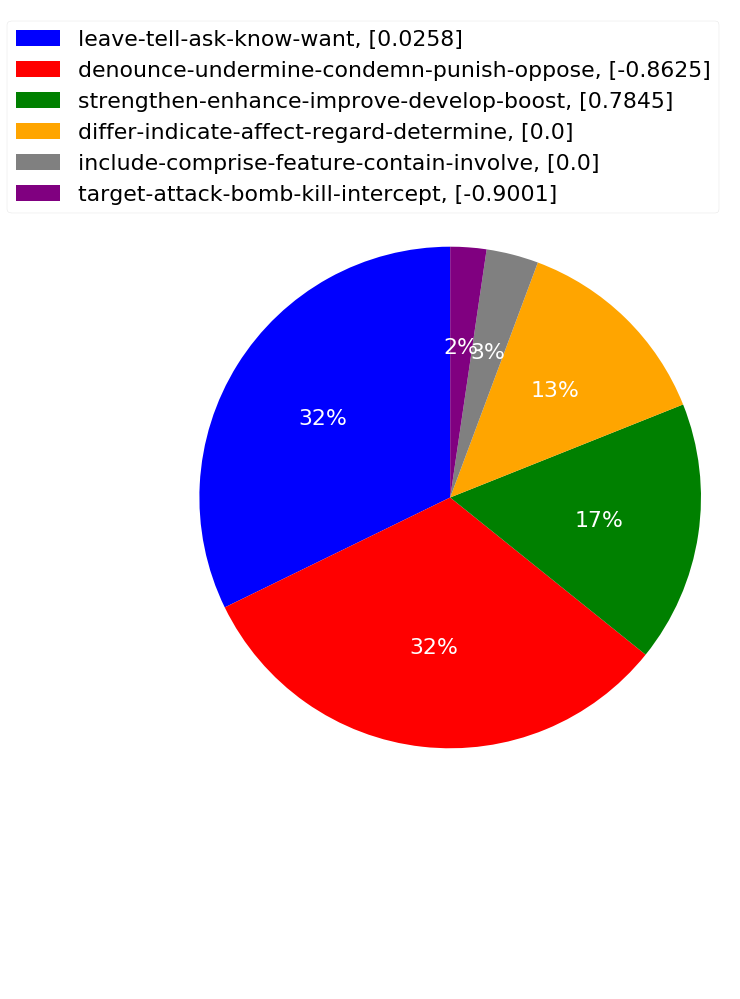

In [18]:
color_choices = ['blue', 'red', 'green', 'orange', 'grey', 'purple']
desc_palette = dict()

desc_pie_sizes = []
desc_pie_labels = []

sum_all_shares = sum([v for k, v in major_desc_sum_dict.items()])
for i, (desc_i, sum_share) in enumerate(sorted([(k, v) for k, v in major_desc_sum_dict.items()], key=lambda x: -x[1])):
    print(rmn_descs[desc_i], '\t\t', sum_share / sum_all_shares)
    desc_palette[desc_i] = color_choices[i % len(color_choices)]
    desc_pie_sizes.append(sum_share)
    desc_pie_labels.append(rmn_descs[desc_i])
sdps = sum(desc_pie_sizes)
for i in range(len(desc_pie_sizes)):
    desc_pie_sizes[i] /= sdps
    
sns.set_context("notebook", font_scale=2.2)
plt.figure(figsize=(10,18))
patches, _, _ = plt.pie(desc_pie_sizes, autopct='%1.0f%%', startangle=90, colors=color_choices, textprops=dict(color="w",fontsize='small'))
plt.legend(patches, desc_pie_labels, loc="best")
plt.axis('equal')

## Main Visualization

In [19]:
def e2er_visualization(b_name, rel, desc_share_d, attn_dict, baseline_d, rmn_descs, desc_palette, key_event_dict):
    print('##################', rel, '##################')
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=3.2, rc={"lines.linewidth": 2}) # previous font: 2.2
    if len(desc_share_d['desc_type']) == 0:
        return
    desc_share_df = pd.DataFrame(data=desc_share_d)
    plt.figure(figsize=(20,8))
    ax = sns.pointplot(data=desc_share_df, x='month_info', y='desc_share', hue='desc_type',
                       ci=None, palette=desc_palette, markers=['o', 'x', '^'], scale=1.5)
    plt.setp([ax.get_lines()],alpha=.5)
    ax.legend(loc='center left', bbox_to_anchor=(0, 1.3))
    new_title = 'Descriptor Type'
    ax.legend_.set_title(new_title)
    for t in ax.legend_.texts:
        t.set_text(rmn_descs[int(t.get_text())].split(',')[0])
    key_event_count = 0
    for xl in ax.get_xticklabels():
        if xl.get_text()[2:] in key_event_dict[b_name][rel].keys():
            key_event_text = key_event_dict[b_name][rel][xl.get_text()[2:]].split('(')[0]
            x_coor = str_to_month(xl.get_text()[2:], year_base) - 1
            plt.axvline(x=x_coor, linestyle='--', color='black', alpha=0.5, lw = 2)
#             trans = ax.get_xaxis_transform() # x in data untis, y in axes fraction
#             ax.annotate(key_event_text, xy=(x_coor, -0.18),  xycoords=trans,
#                         xytext=(0, -.325 - (key_event_count) * .15), textcoords=trans,
#                         bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
#                         arrowprops=dict(arrowstyle="-|>", lw=2,
#                                         connectionstyle="angle,angleA=0,angleB=80,rad=20"))
            key_event_count += 1
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('Descriptor Weight')
    plt.show()
    #ax.figure.savefig('figures/' + rel + '.png', dpi=200, bbox_inches='tight')
    
    curr_non_trivial_descs = set(desc_share_d['desc_type'])
    for k in attn_dict.keys():
        if k not in curr_non_trivial_descs:
            continue
        title = rmn_descs[k]
        print(title)
        attn_df = pd.DataFrame(data={'attn_word': attn_dict[k]['attn_word'],
                                     'month_info': attn_dict[k]['month_info'],
                                     'attn_score': attn_dict[k]['attn_score']})
        keyword_list = attn_dict[k]['keyword_list']
        month_list = attn_dict[k]['month_list']
        attn_array = np.zeros([len(keyword_list), len(month_list)])
        max_attn_score = 0
        for i, keyword in enumerate(keyword_list):
            for j, month in enumerate(month_list):
                attn_array[i][j] = attn_df[(attn_df.attn_word == keyword) &
                                           (attn_df.month_info == month)]['attn_score']
                if attn_array[i][j] > max_attn_score:
                    max_attn_score = attn_array[i][j]
        max_column_attn_scores = [np.max([attn_array[_i][j] for _i in range(len(attn_array))])
                                  for j, month in enumerate(month_list)]
        for i, keyword in enumerate(keyword_list): # normalization
            max_row_attn_score = np.max(attn_array[i])
            for j, month in enumerate(month_list):
                attn_array[i][j] = 1.0 * attn_array[i][j] / max_attn_score
                # alt: use max_attn_score for global normalization
        plt.figure(figsize=(18,len(keyword_list)/1.8))
#         print(attn_array.mean(axis=1))
        ax = sns.heatmap(attn_array, xticklabels=['20'+_m for _m in month_list], yticklabels=keyword_list,
                         linewidths=.05, linecolor='dimgray', cmap=desc_palette[k].capitalize()+'s', cbar=False)
        key_event_count = 0
        for xl in ax.get_xticklabels():
            if xl.get_text()[2:] in key_event_dict[b_name][rel].keys():
                key_event_text = key_event_dict[b_name][rel][xl.get_text()[2:]].split('(')[0]
#                 x_coor = str_to_month(xl.get_text()[2:], year_base) - 1
#                 trans = ax.get_xaxis_transform() # x in data untis, y in axes fraction
#                 ax.annotate(key_event_text, xy=(x_coor + .5, -.5),  xycoords=trans,
#                             xytext=(0, -.75 - (key_event_count) * .25), textcoords=trans,
#                             bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
#                             arrowprops=dict(arrowstyle="-|>", lw=2,
#                                             connectionstyle="angle,angleA=0,angleB=80,rad=20"))
                key_event_count += 1
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        plt.show()
#         ax.figure.savefig('figures/_' + rel + '_attn_' + str(k) + '.png', dpi=300, bbox_inches='tight')
        
        # word frequency baseline
        title = rmn_descs[k] + ' (Baseline)'
        print(title)
        attn_df = pd.DataFrame(data={'base_word': baseline_d[k]['base_word'],
                                     'month_info': baseline_d[k]['month_info'],
                                     'base_score': baseline_d[k]['base_score']})
        keyword_list = baseline_d[k]['keyword_list']
        month_list = baseline_d[k]['month_list']
        attn_array = np.zeros([len(keyword_list), len(month_list)])
        max_attn_score = 0
        for i, keyword in enumerate(keyword_list):
            for j, month in enumerate(month_list):
                attn_array[i][j] = attn_df[(attn_df.base_word == keyword) &
                                           (attn_df.month_info == month)]['base_score']
                if attn_array[i][j] > max_attn_score:
                    max_attn_score = attn_array[i][j]
        max_column_attn_scores = [np.max([attn_array[_i][j] for _i in range(len(attn_array))])
                                  for j, month in enumerate(month_list)]
        for i, keyword in enumerate(keyword_list): # normalization
            max_row_attn_score = np.max(attn_array[i])
            for j, month in enumerate(month_list):
                attn_array[i][j] = 1.0 * attn_array[i][j] / max_attn_score
                # alt: use max_attn_score for global normalization
        plt.figure(figsize=(18,len(keyword_list)/1.8))

        ax = sns.heatmap(attn_array, xticklabels=['20'+_m for _m in month_list], yticklabels=keyword_list,
                         linewidths=.05, linecolor='dimgray', cmap=desc_palette[k].capitalize()+'s', cbar=False)
        key_event_count = 0
        for xl in ax.get_xticklabels():
            if xl.get_text()[2:] in key_event_dict[b_name][rel].keys():
                key_event_text = key_event_dict[b_name][rel][xl.get_text()[2:]].split('(')[0]
#                 x_coor = str_to_month(xl.get_text()[2:], year_base) - 1
#                 trans = ax.get_xaxis_transform() # x in data untis, y in axes fraction
#                 ax.annotate(key_event_text, xy=(x_coor + .5, -.5),  xycoords=trans,
#                             xytext=(0, -.75 - (key_event_count) * .25), textcoords=trans,
#                             bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
#                             arrowprops=dict(arrowstyle="-|>", lw=2,
#                                             connectionstyle="angle,angleA=0,angleB=80,rad=20"))
                key_event_count += 1
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        plt.show()
#         ax.figure.savefig('figures/_' + rel + '_freq_' + str(k) + '.png', dpi=300, bbox_inches='tight')

################## U.S. AND U.K. ##################


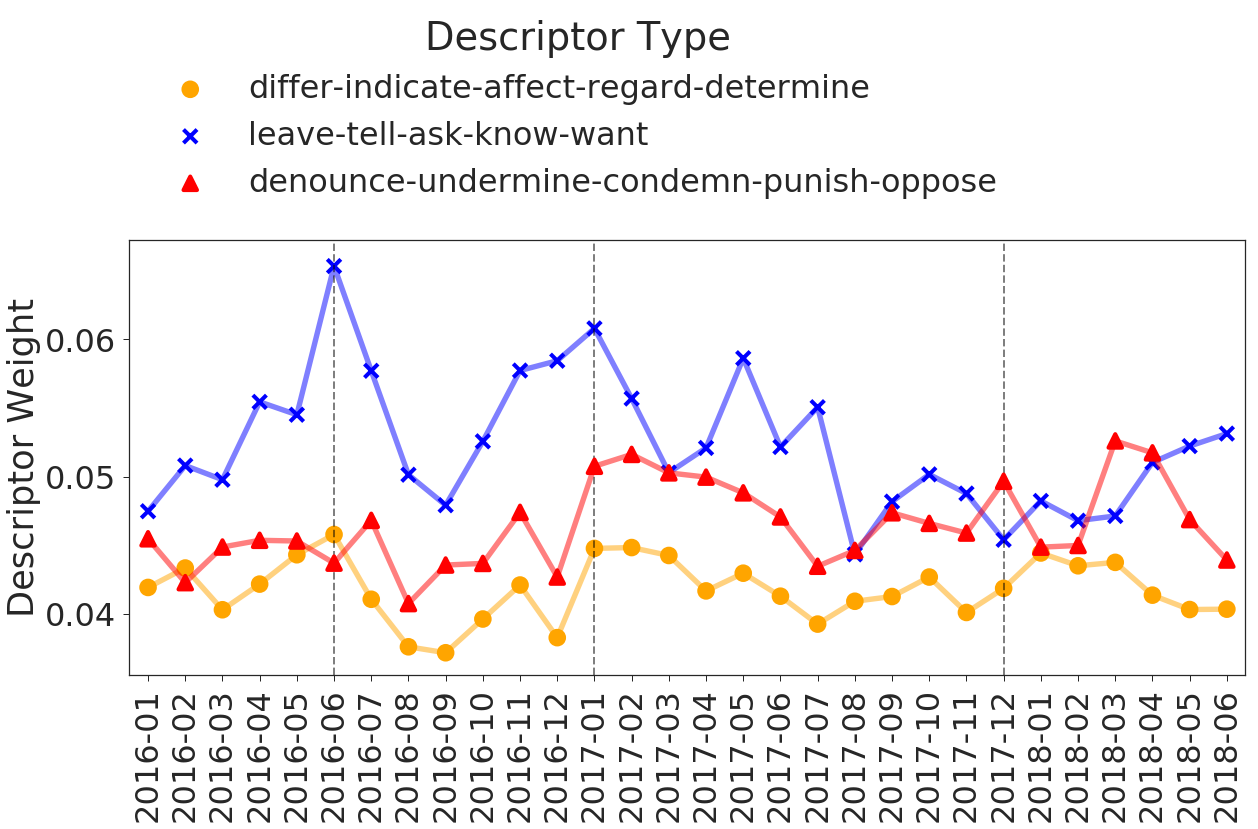

differ-indicate-affect-regard-determine, [0.0]


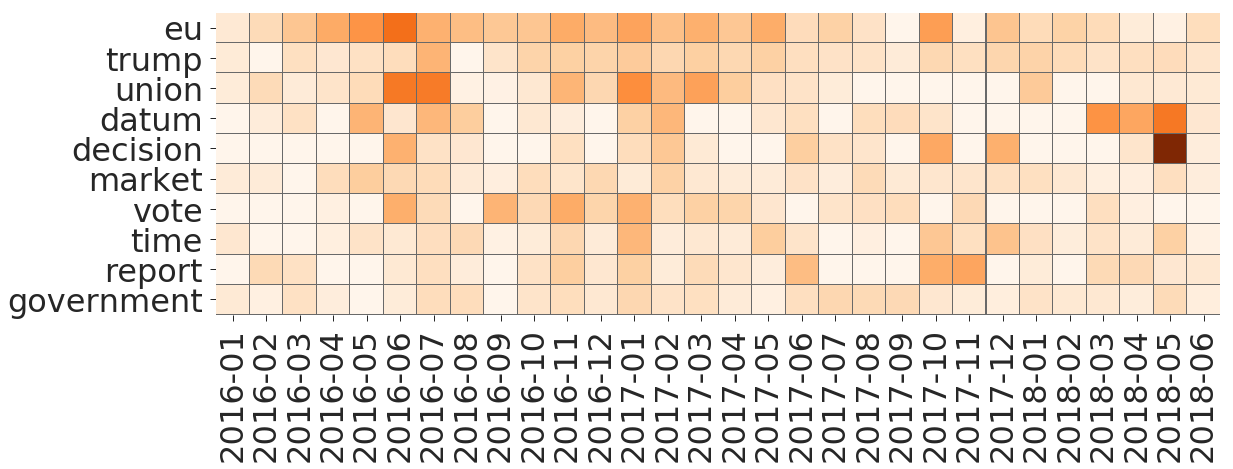

differ-indicate-affect-regard-determine, [0.0] (Baseline)


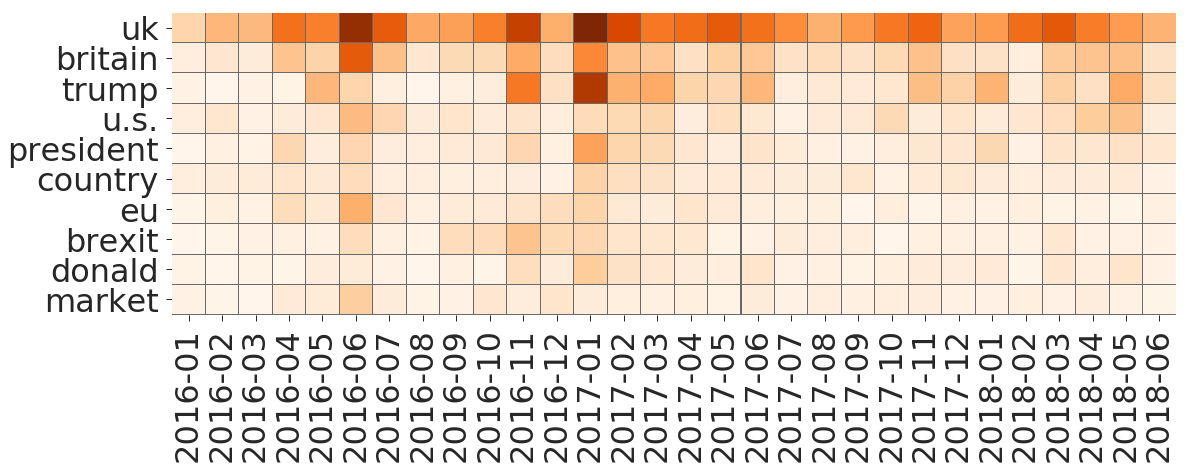

leave-tell-ask-know-want, [0.0258]


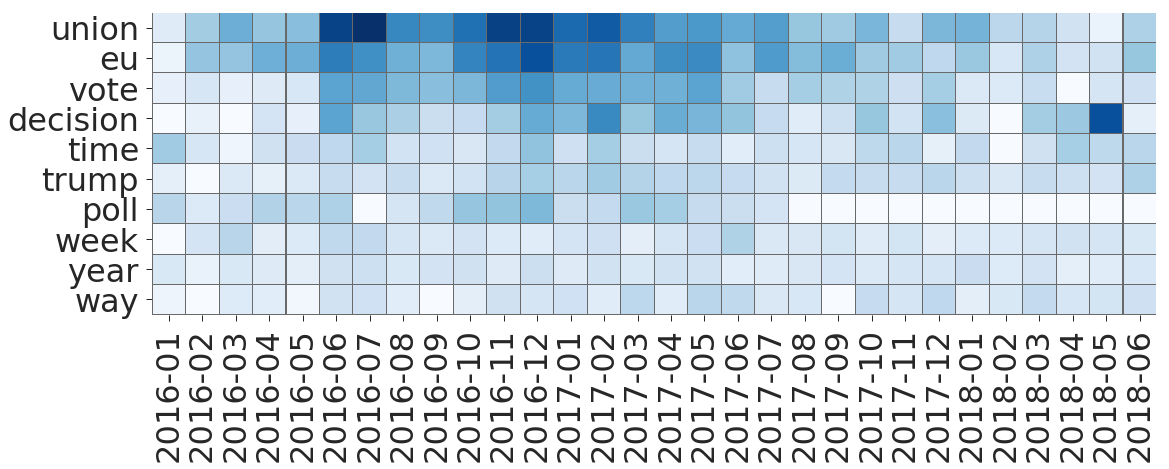

leave-tell-ask-know-want, [0.0258] (Baseline)


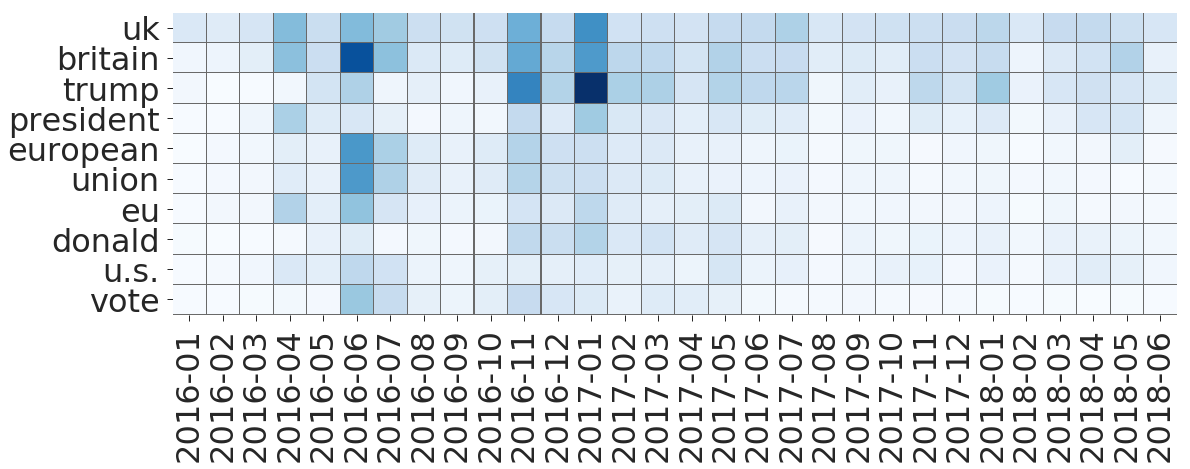

denounce-undermine-condemn-punish-oppose, [-0.8625]


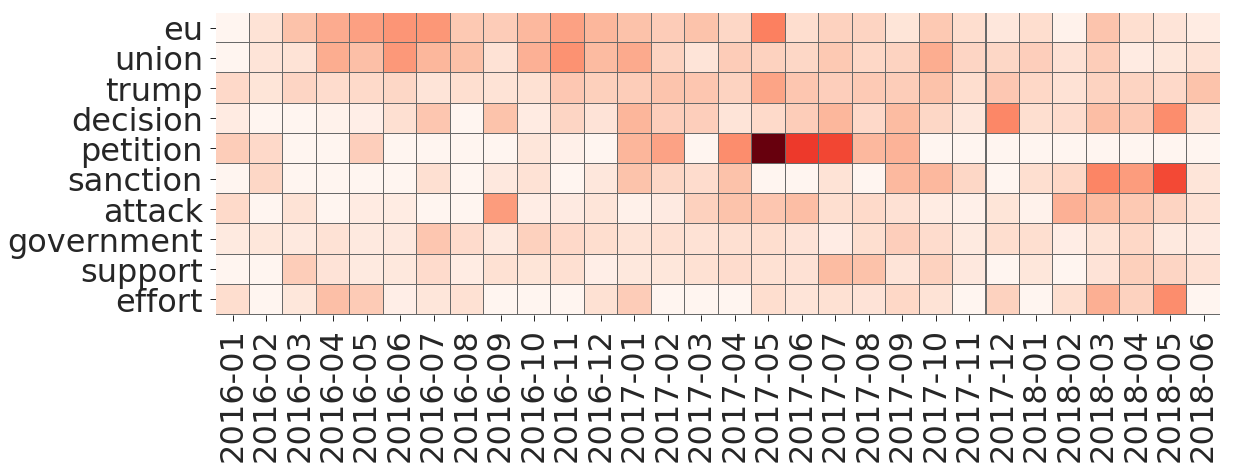

denounce-undermine-condemn-punish-oppose, [-0.8625] (Baseline)


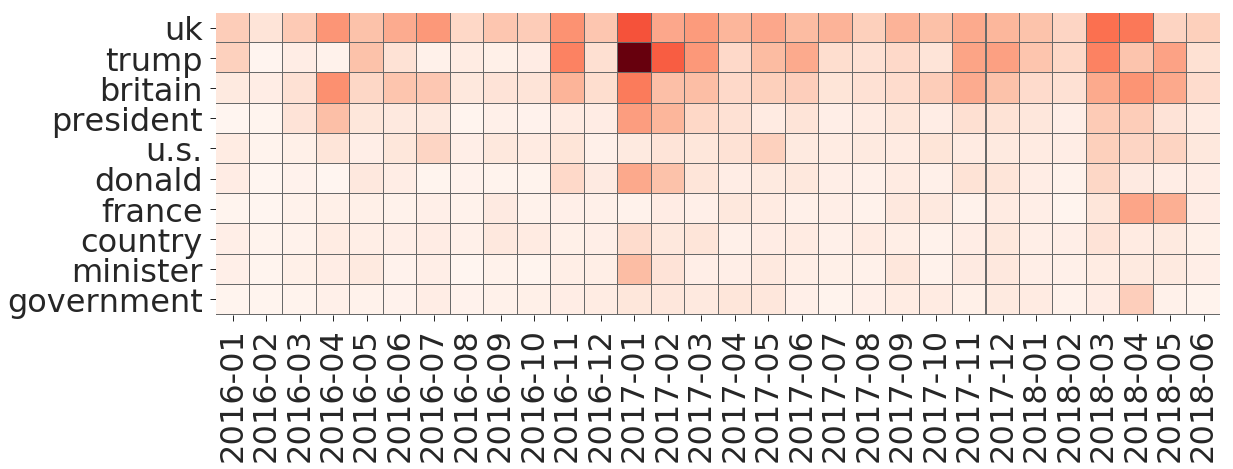

################## U.S. AND Canada ##################


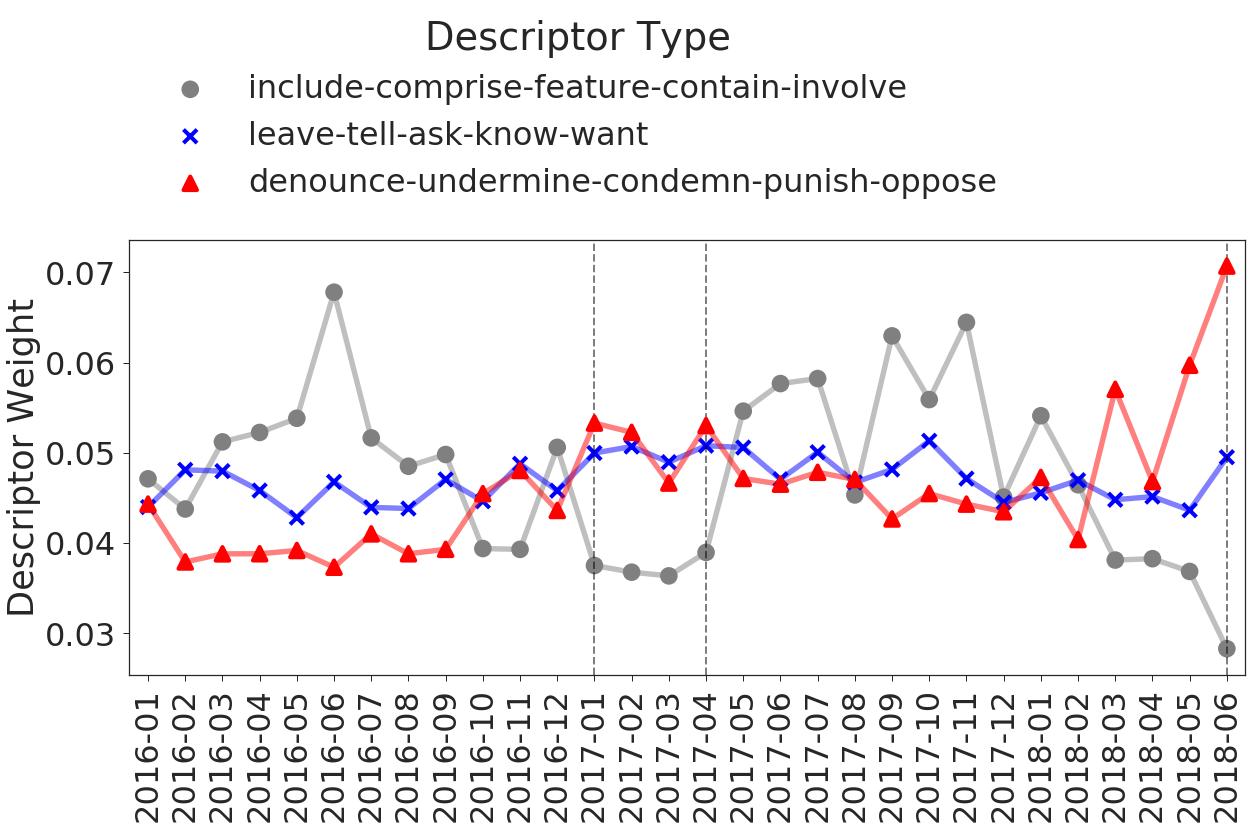

include-comprise-feature-contain-involve, [0.0]


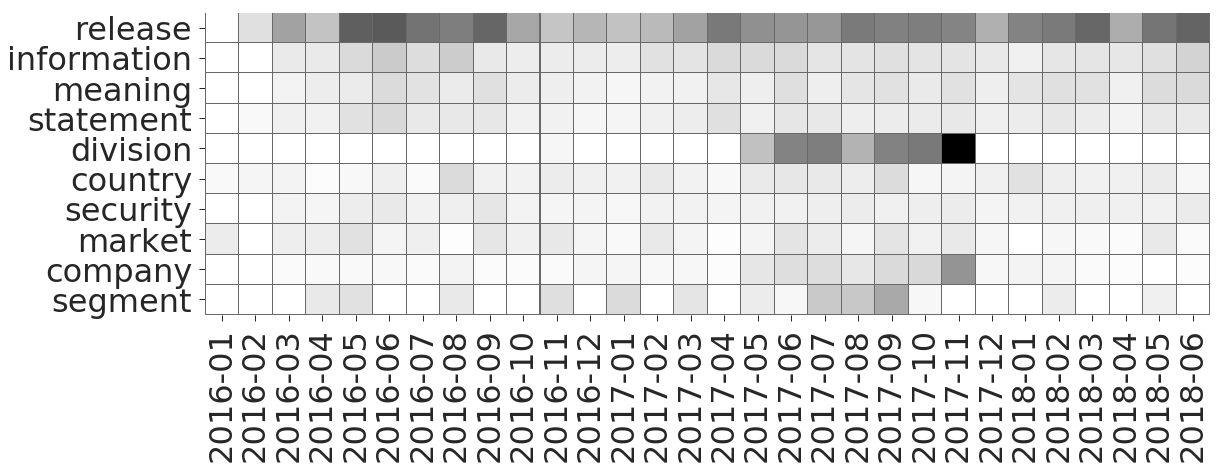

include-comprise-feature-contain-involve, [0.0] (Baseline)


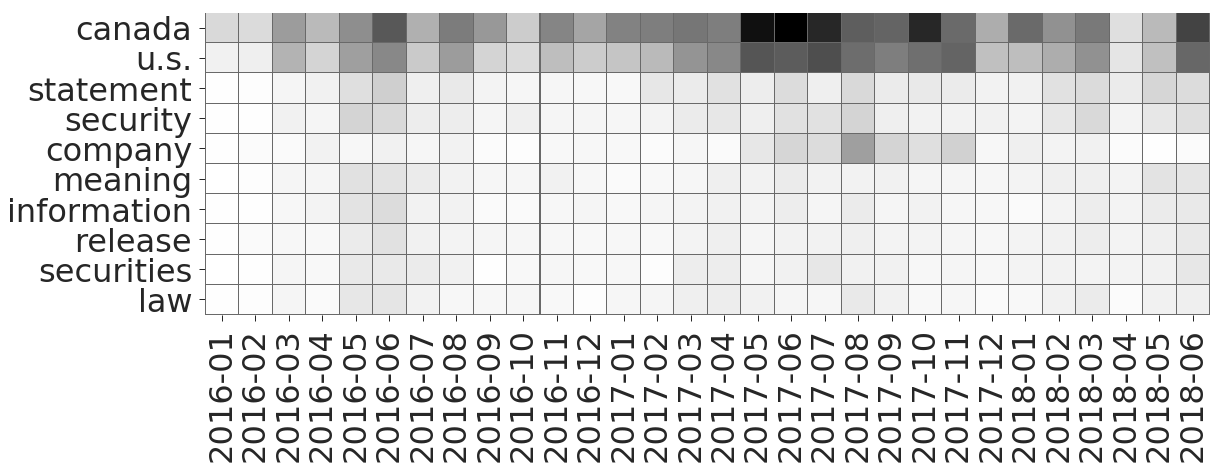

leave-tell-ask-know-want, [0.0258]


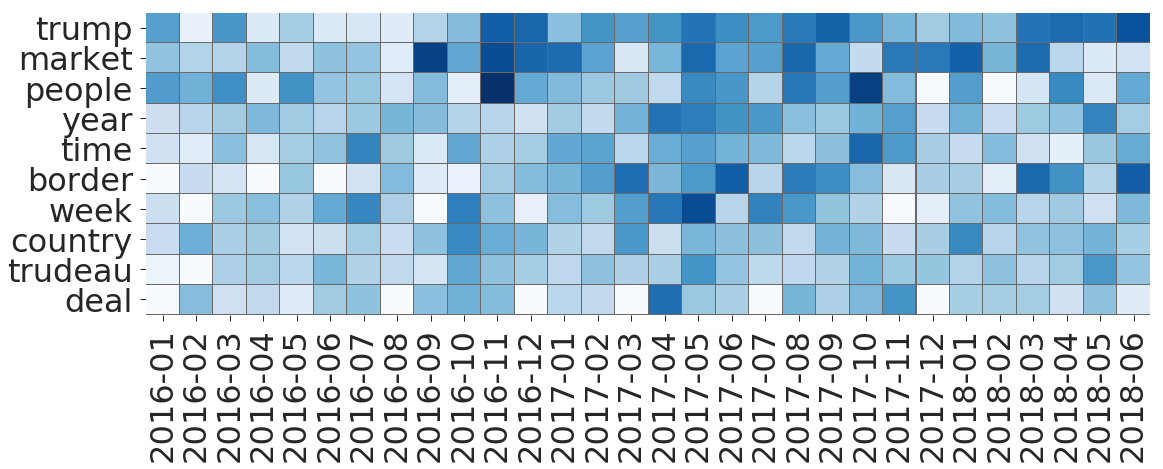

leave-tell-ask-know-want, [0.0258] (Baseline)


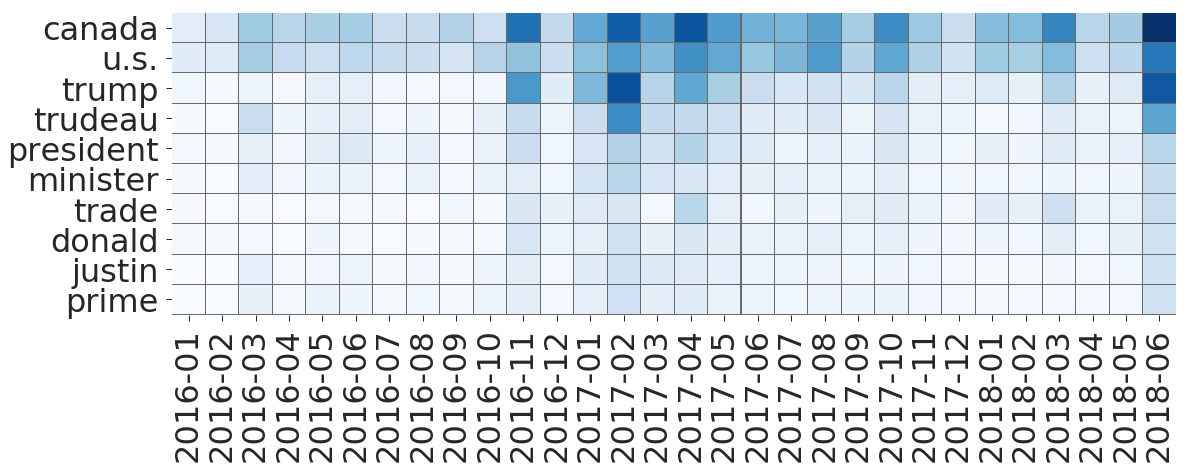

denounce-undermine-condemn-punish-oppose, [-0.8625]


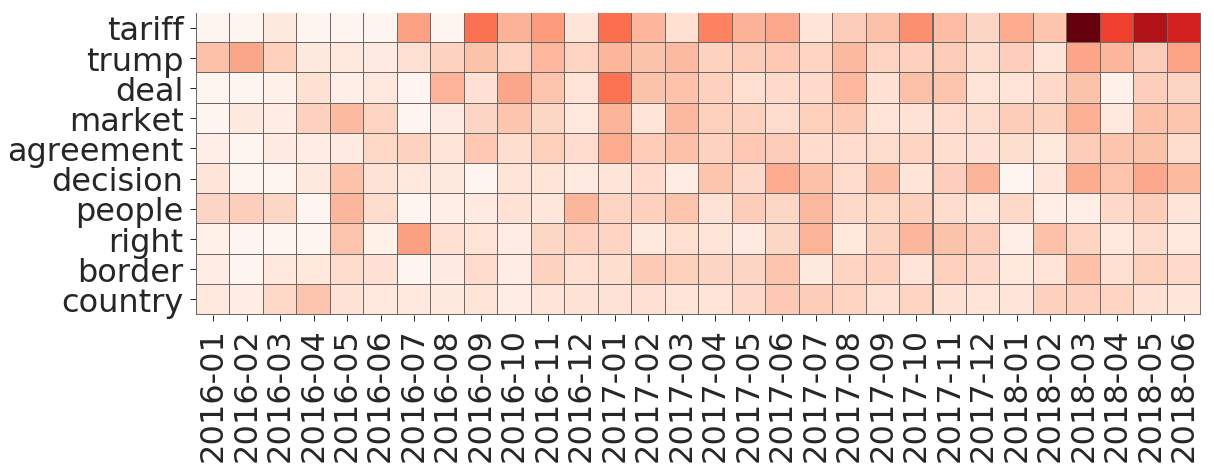

denounce-undermine-condemn-punish-oppose, [-0.8625] (Baseline)


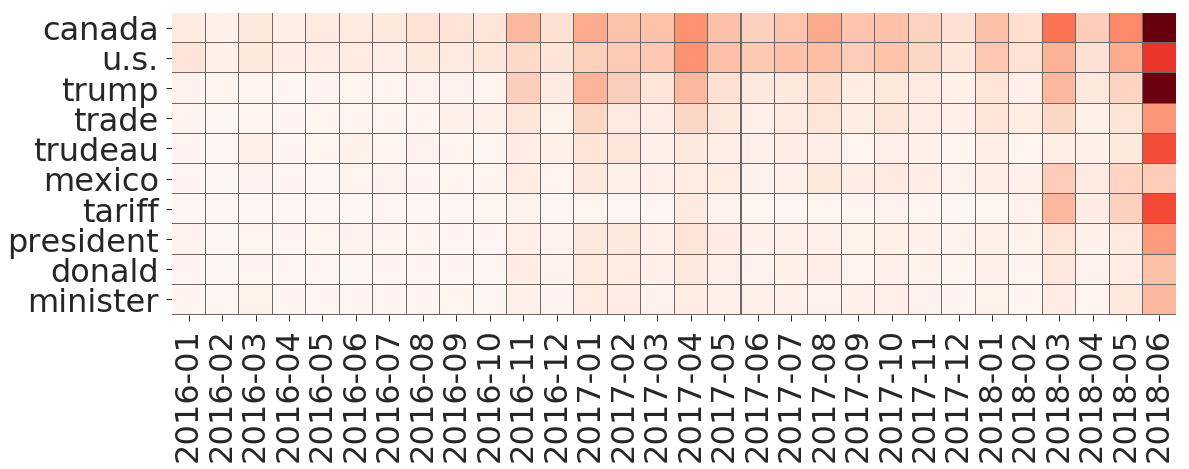

################## U.S. AND Russia ##################


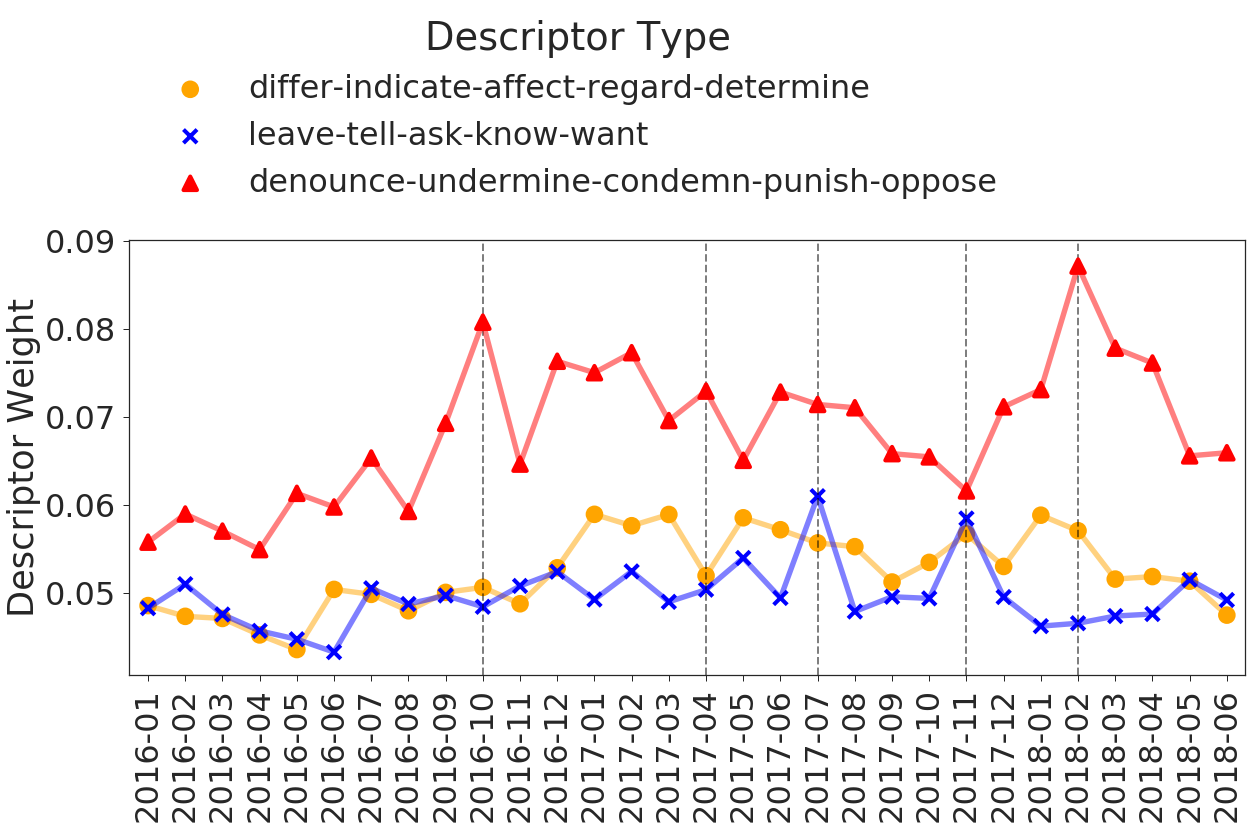

differ-indicate-affect-regard-determine, [0.0]


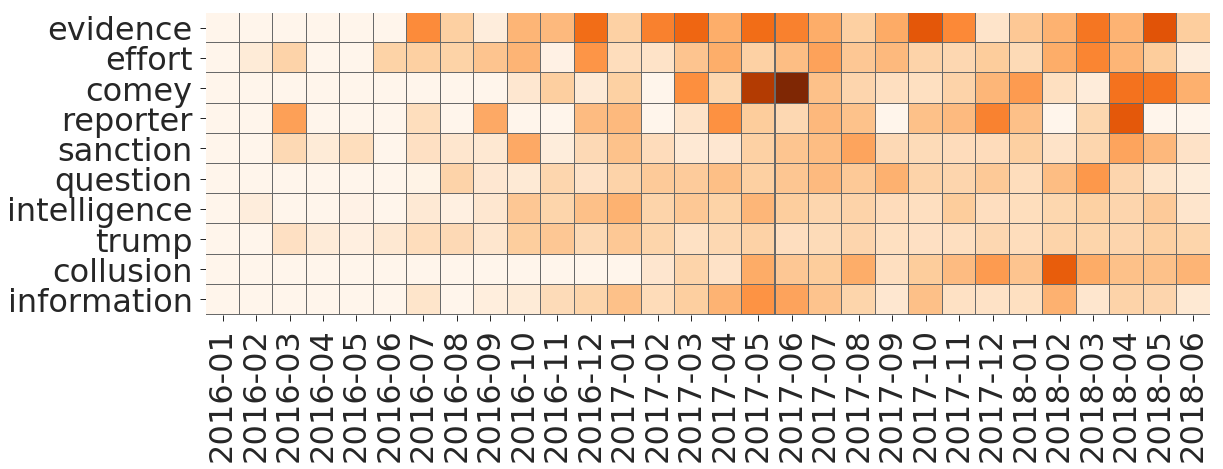

differ-indicate-affect-regard-determine, [0.0] (Baseline)


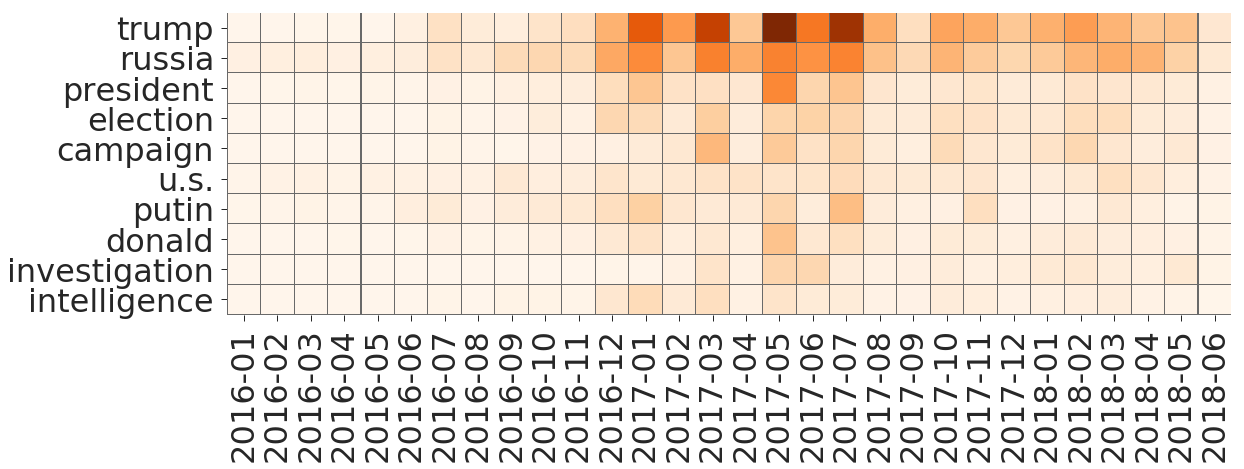

leave-tell-ask-know-want, [0.0258]


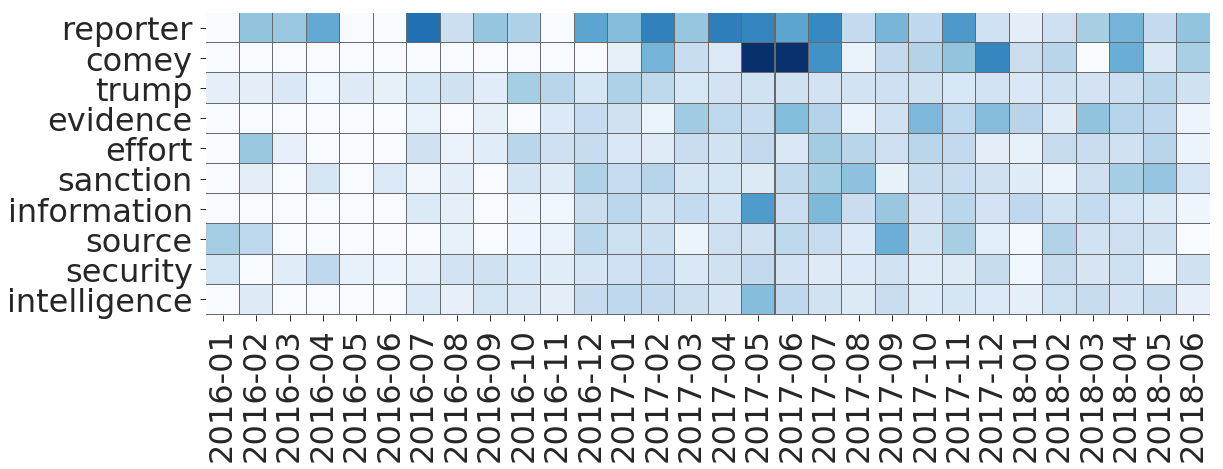

leave-tell-ask-know-want, [0.0258] (Baseline)


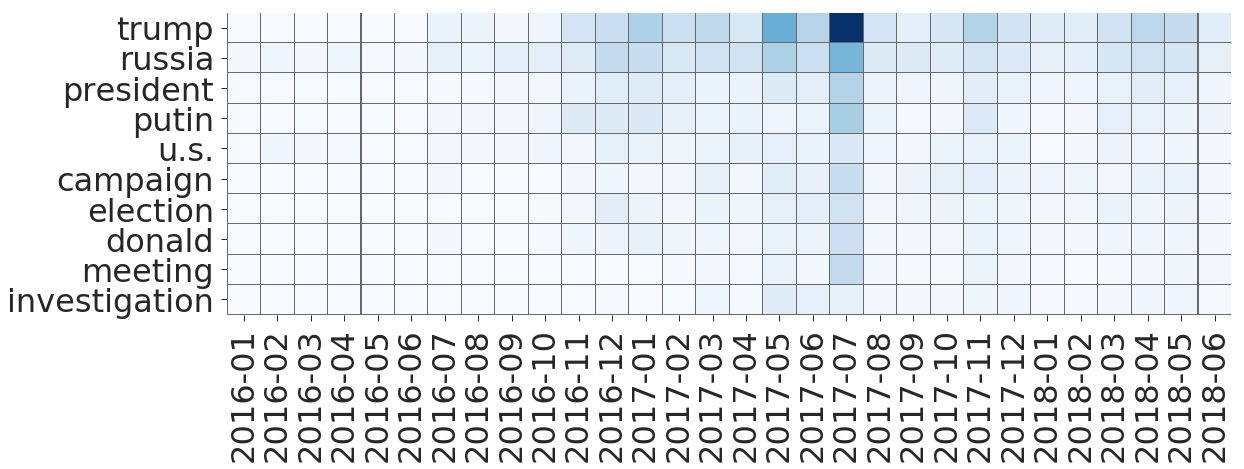

denounce-undermine-condemn-punish-oppose, [-0.8625]


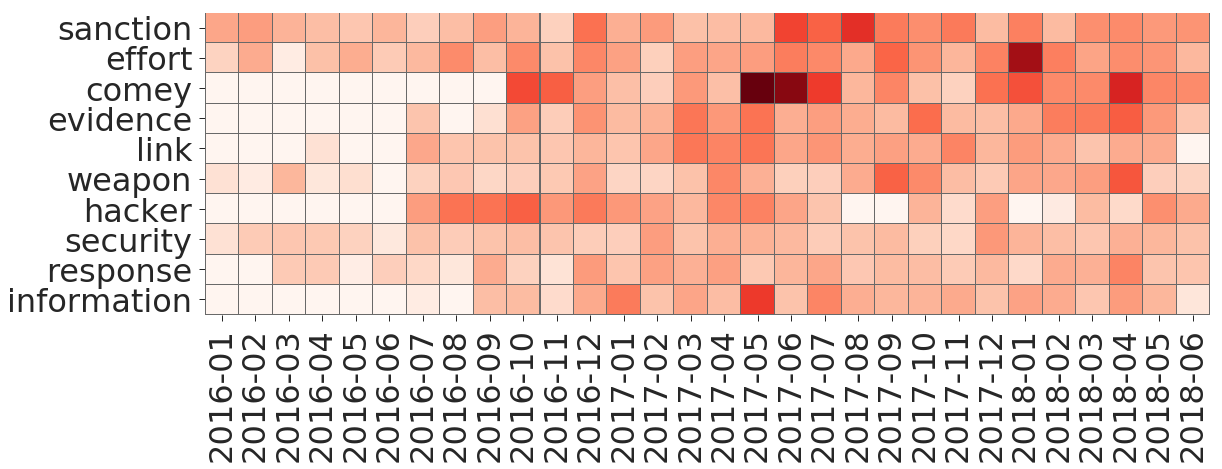

denounce-undermine-condemn-punish-oppose, [-0.8625] (Baseline)


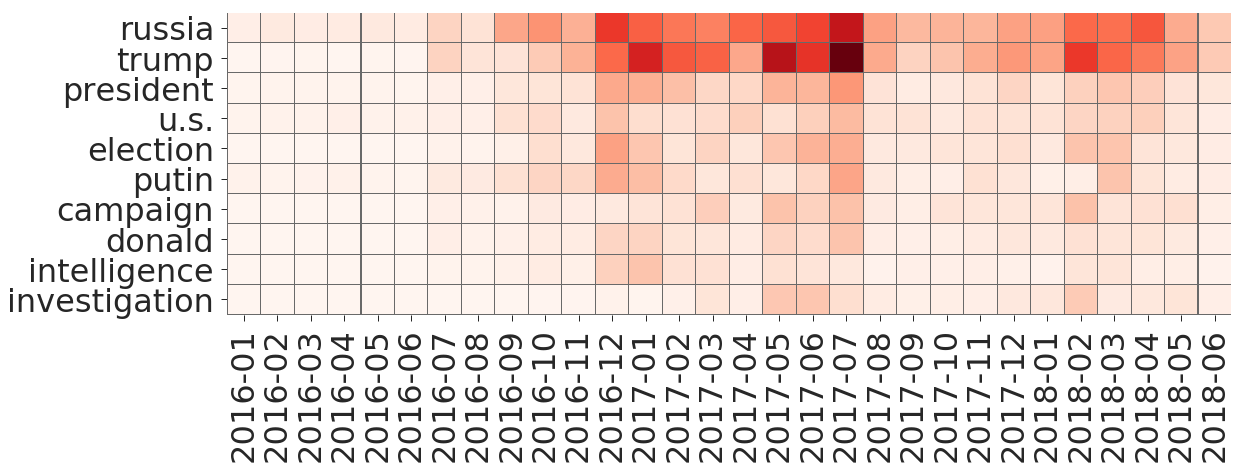

################## U.S. AND Syria ##################


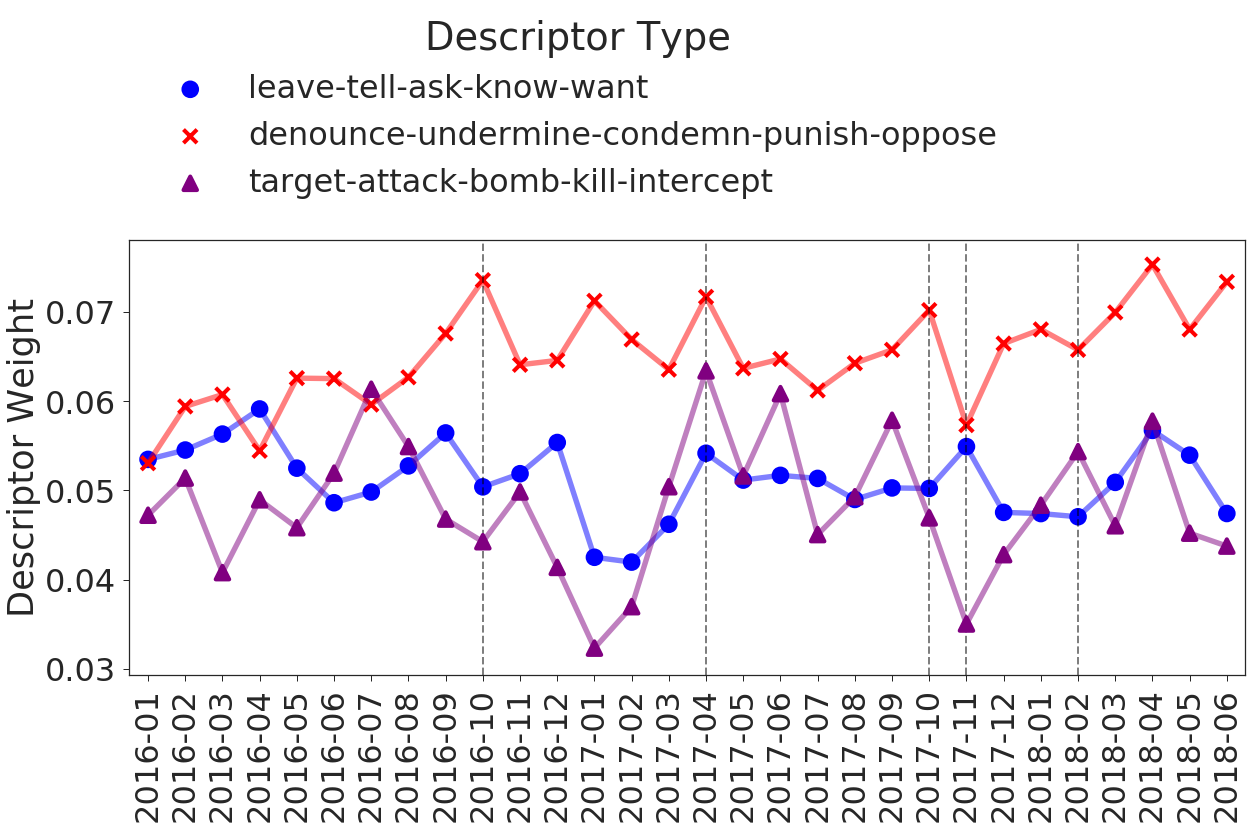

leave-tell-ask-know-want, [0.0258]


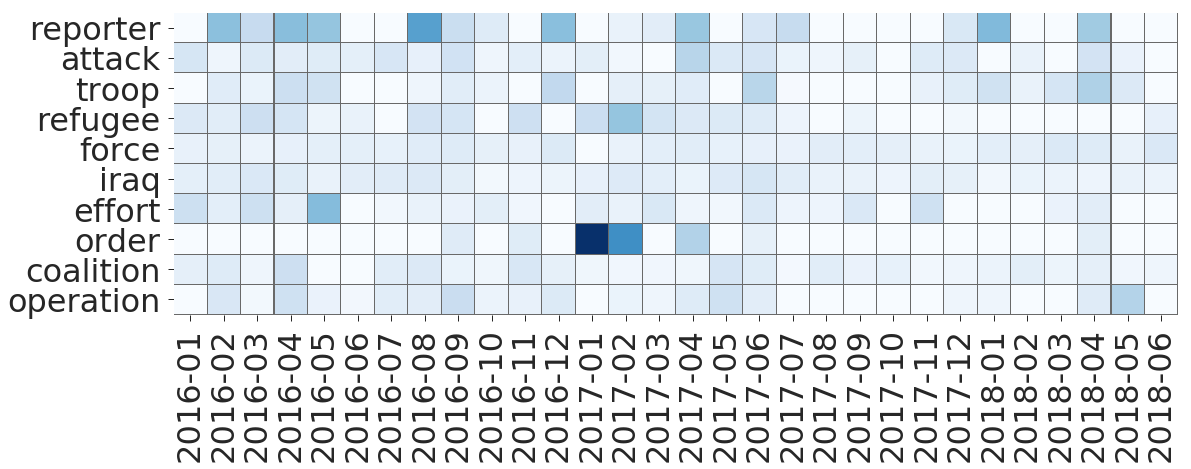

leave-tell-ask-know-want, [0.0258] (Baseline)


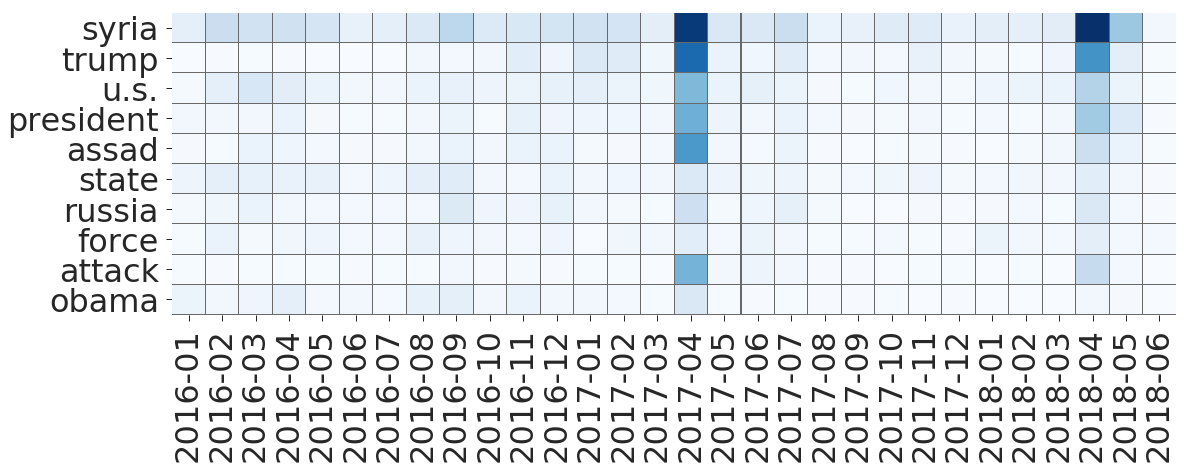

denounce-undermine-condemn-punish-oppose, [-0.8625]


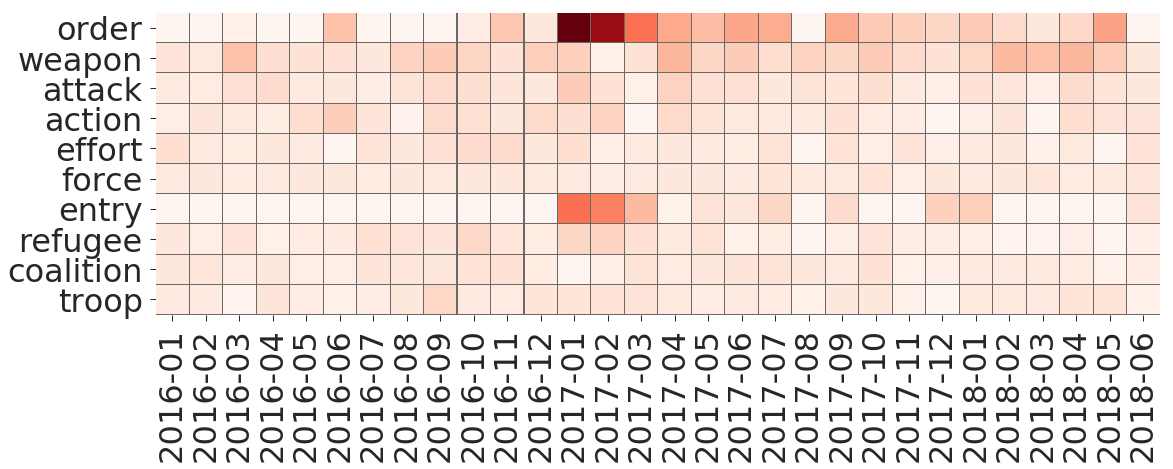

denounce-undermine-condemn-punish-oppose, [-0.8625] (Baseline)


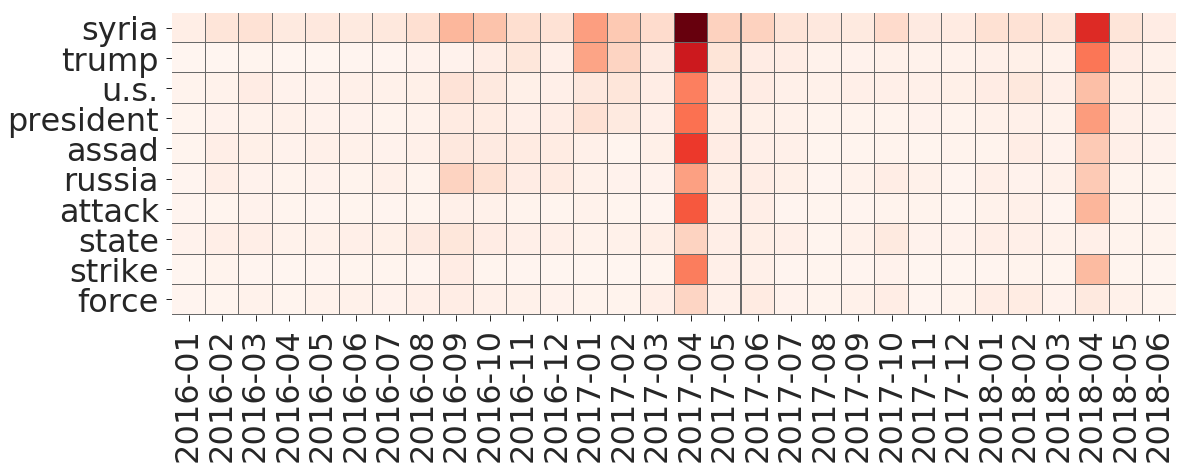

target-attack-bomb-kill-intercept, [-0.9001]


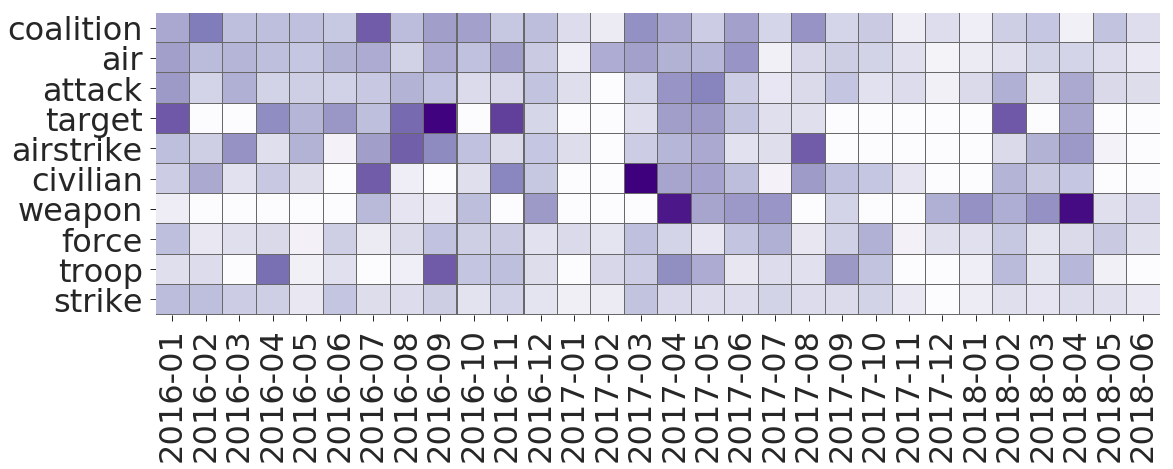

target-attack-bomb-kill-intercept, [-0.9001] (Baseline)


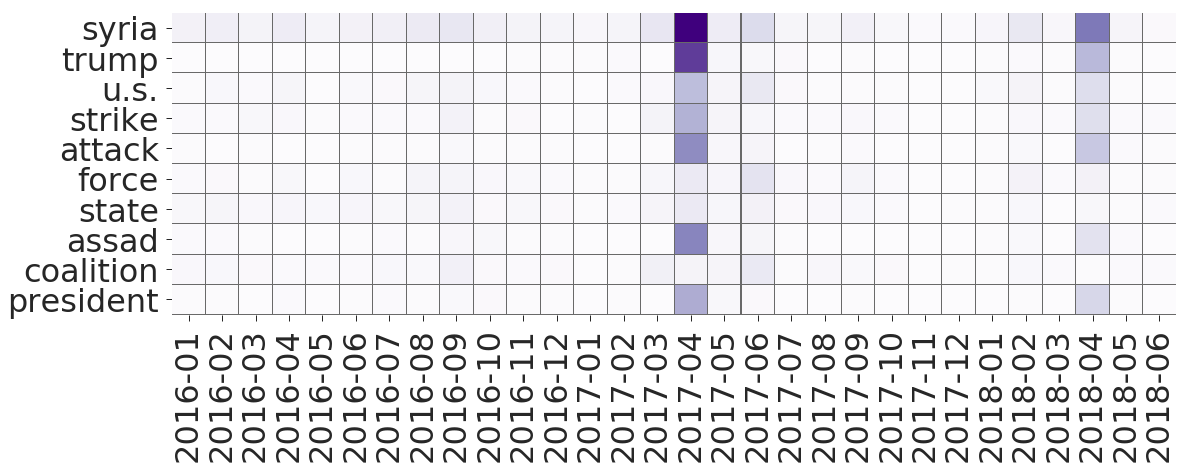

################## U.S. AND China ##################


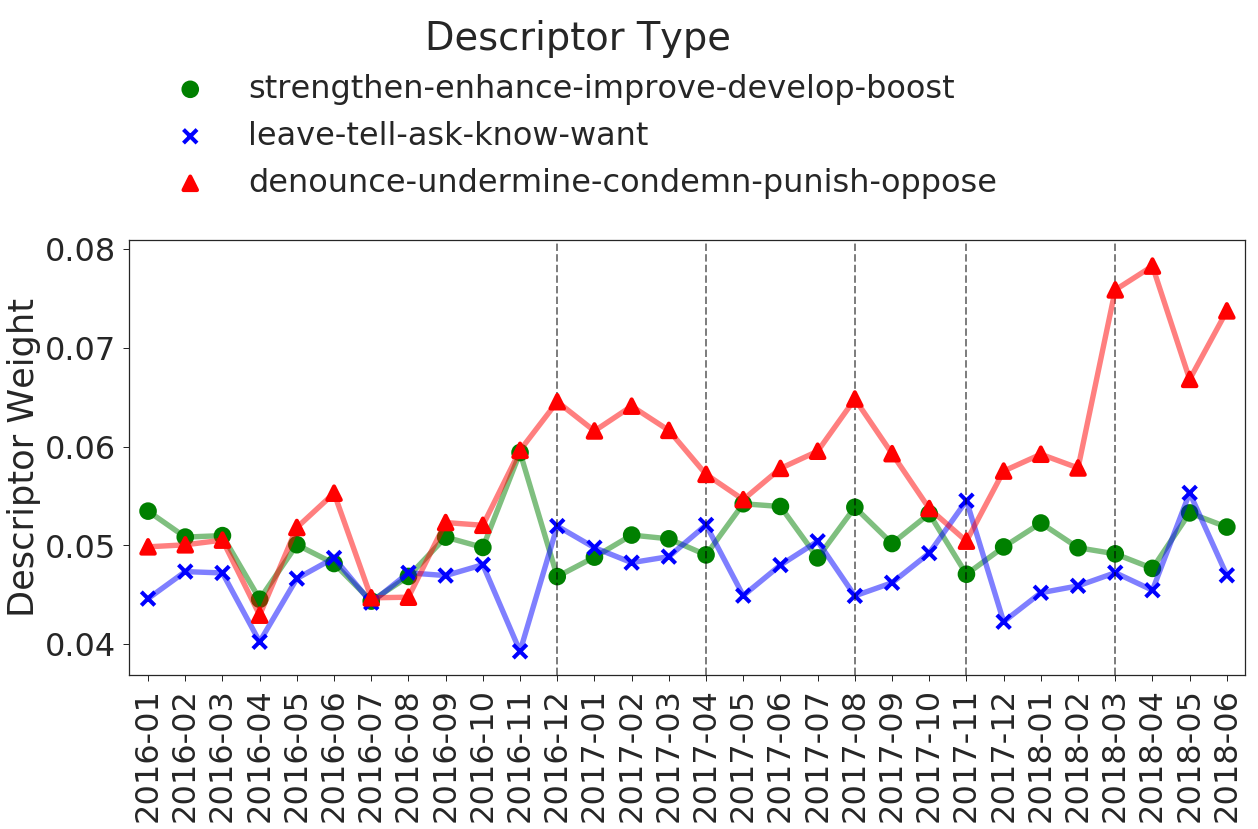

strengthen-enhance-improve-develop-boost, [0.7845]


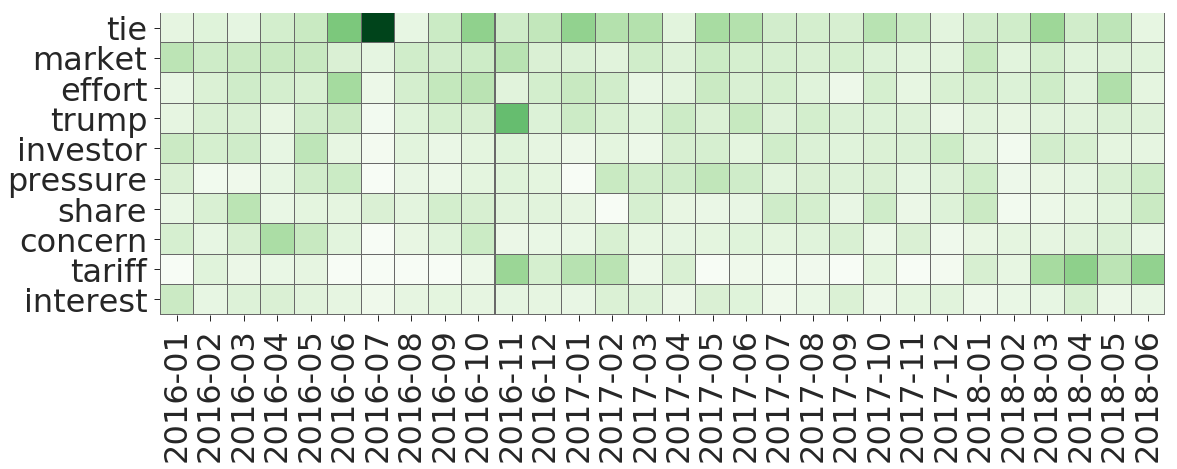

strengthen-enhance-improve-develop-boost, [0.7845] (Baseline)


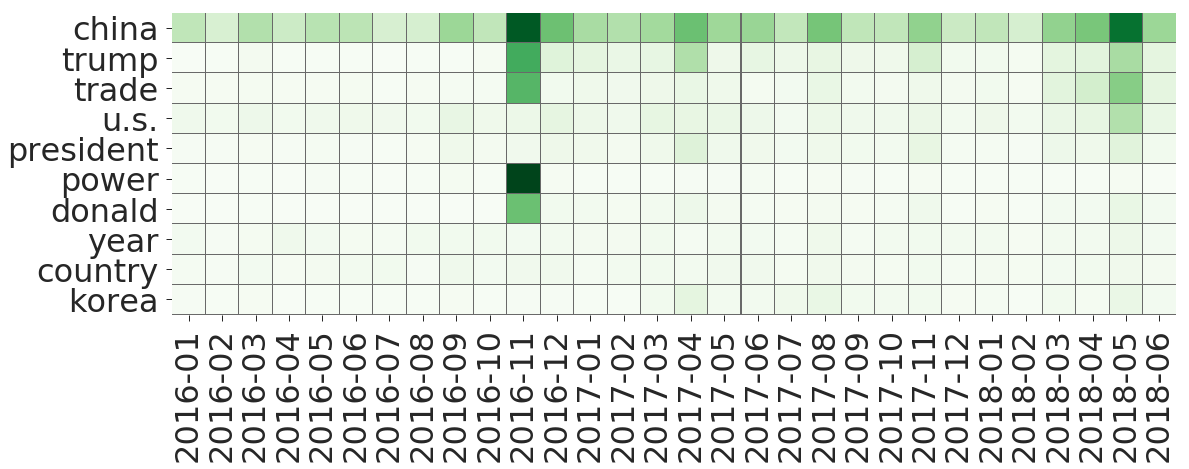

leave-tell-ask-know-want, [0.0258]


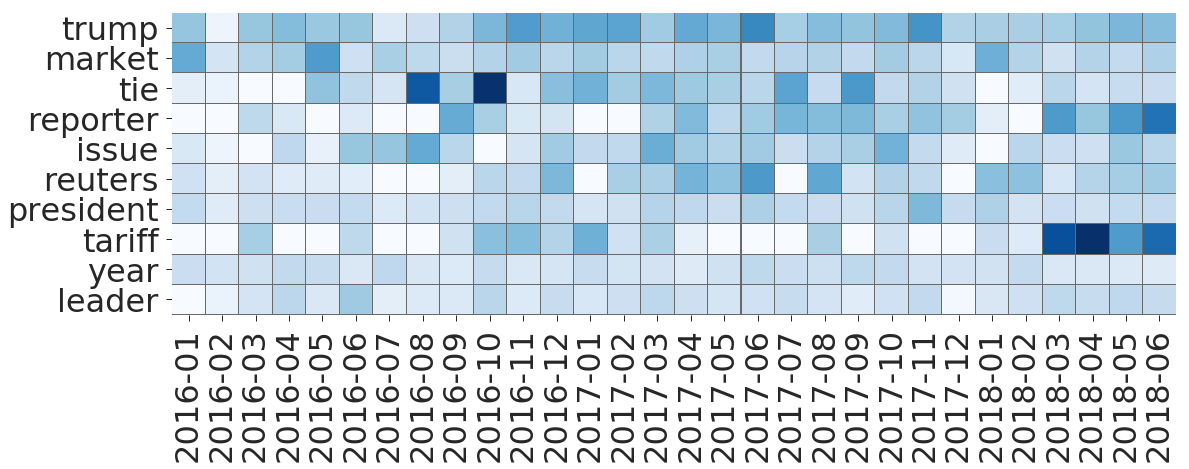

leave-tell-ask-know-want, [0.0258] (Baseline)


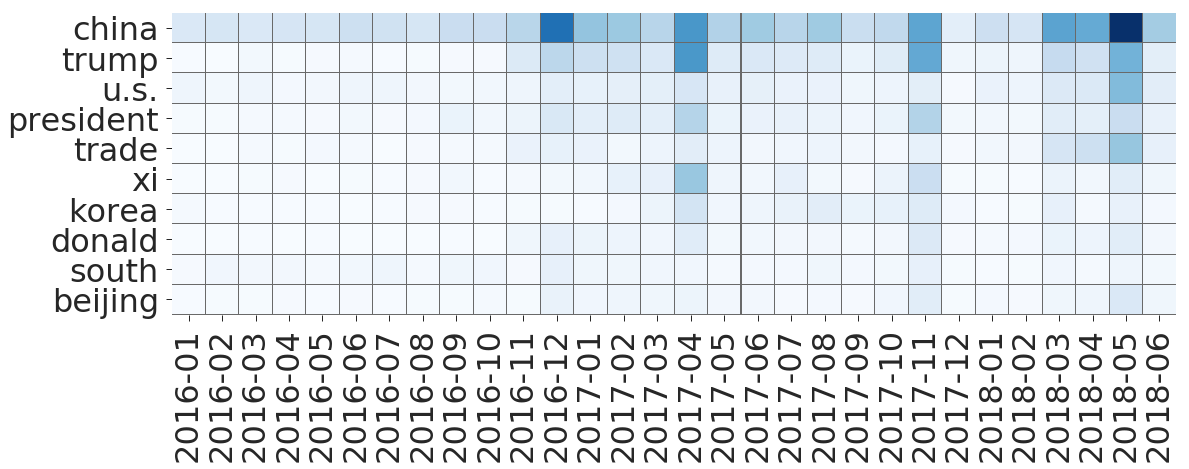

denounce-undermine-condemn-punish-oppose, [-0.8625]


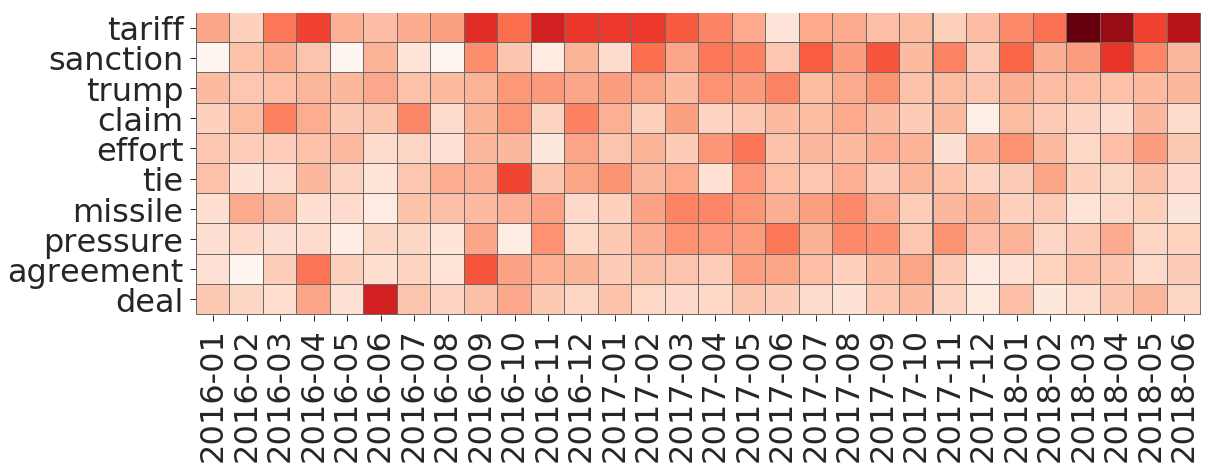

denounce-undermine-condemn-punish-oppose, [-0.8625] (Baseline)


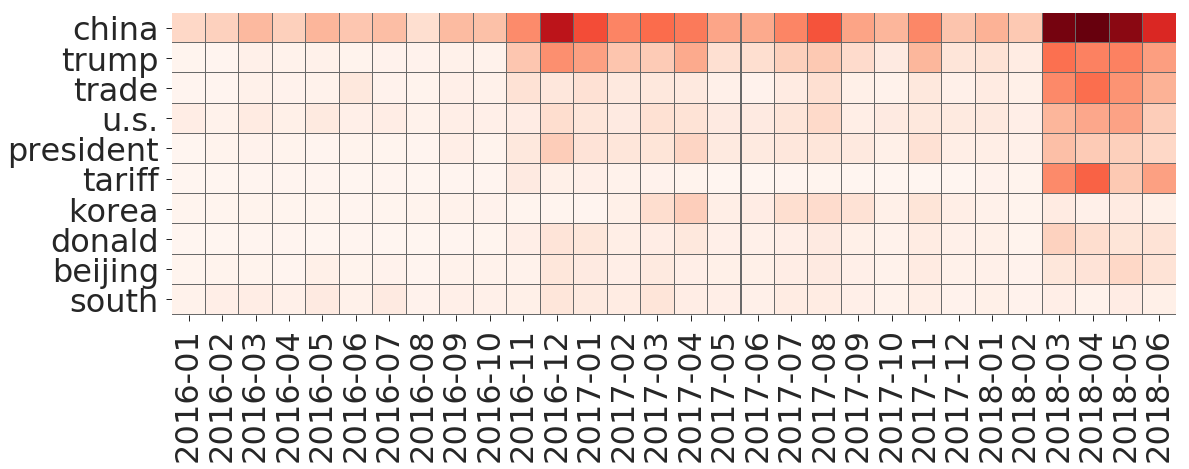

################## China AND India ##################


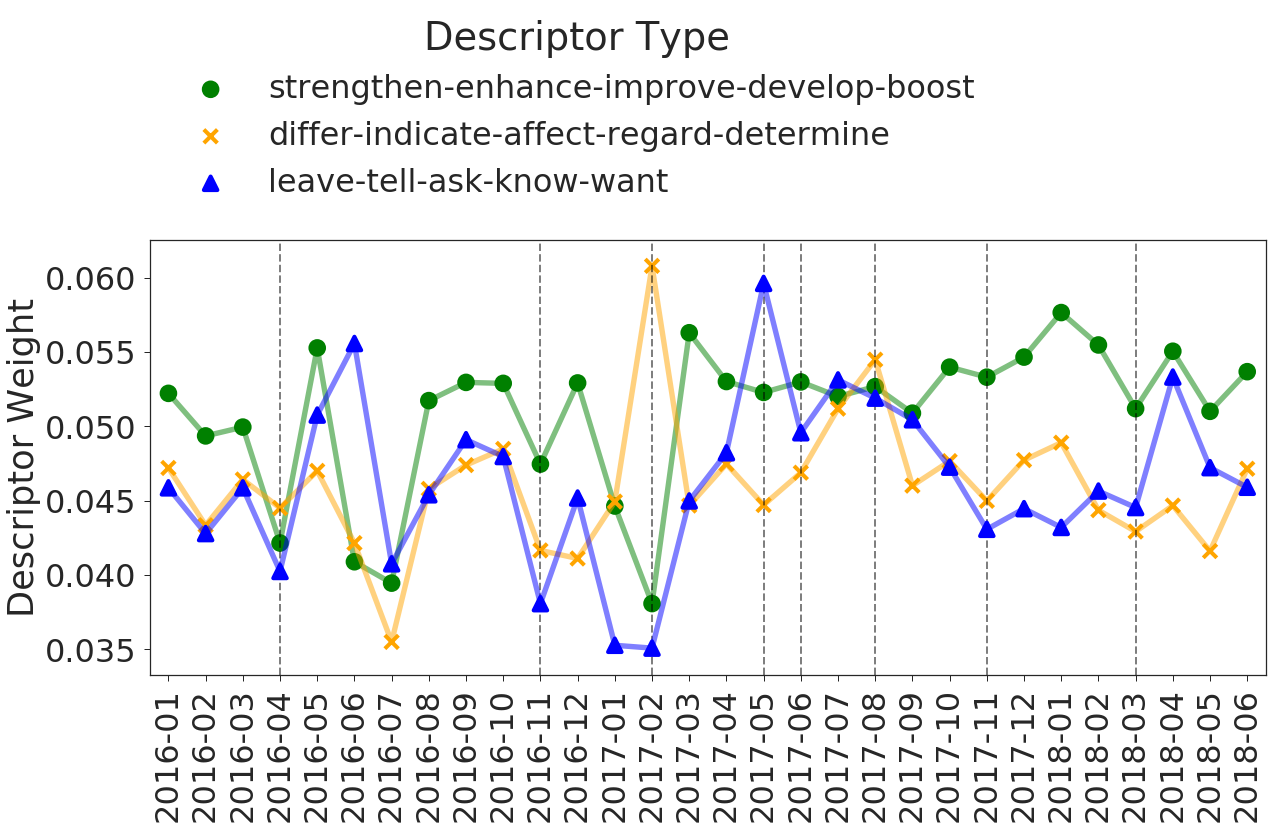

strengthen-enhance-improve-develop-boost, [0.7845]


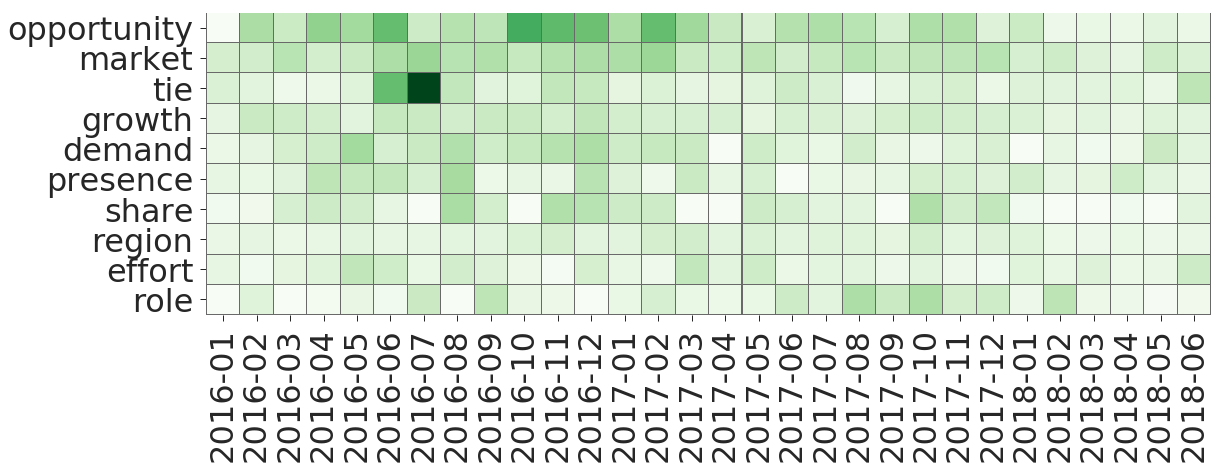

strengthen-enhance-improve-develop-boost, [0.7845] (Baseline)


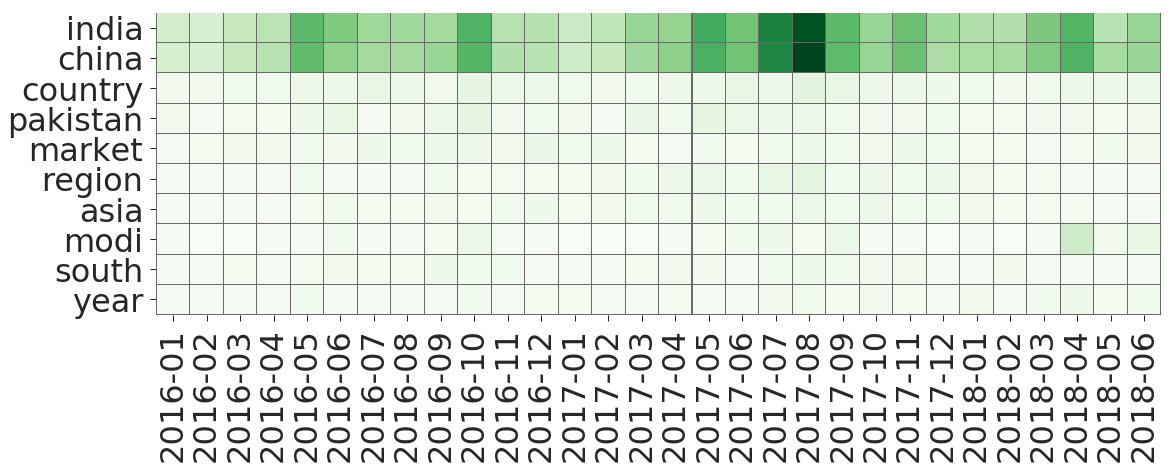

differ-indicate-affect-regard-determine, [0.0]


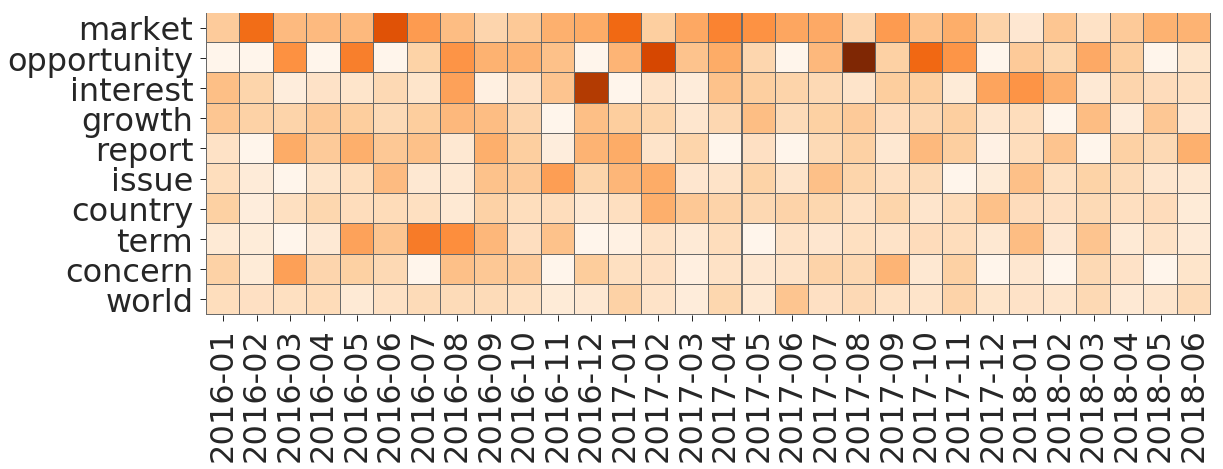

differ-indicate-affect-regard-determine, [0.0] (Baseline)


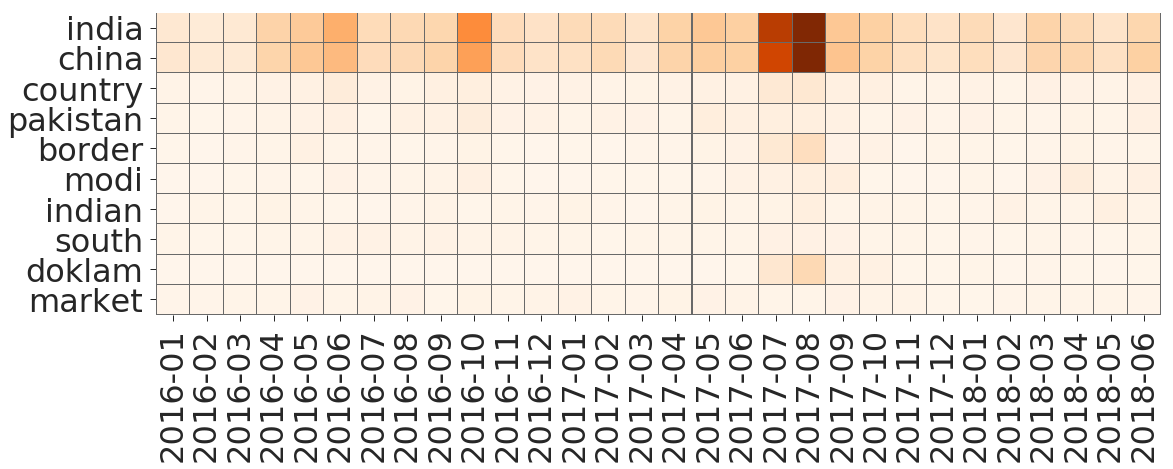

leave-tell-ask-know-want, [0.0258]


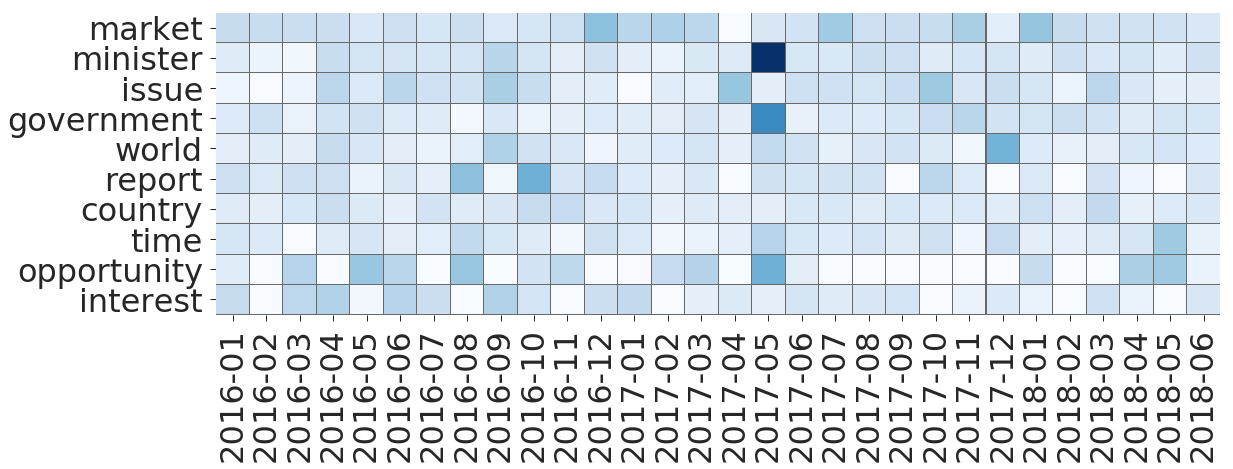

leave-tell-ask-know-want, [0.0258] (Baseline)


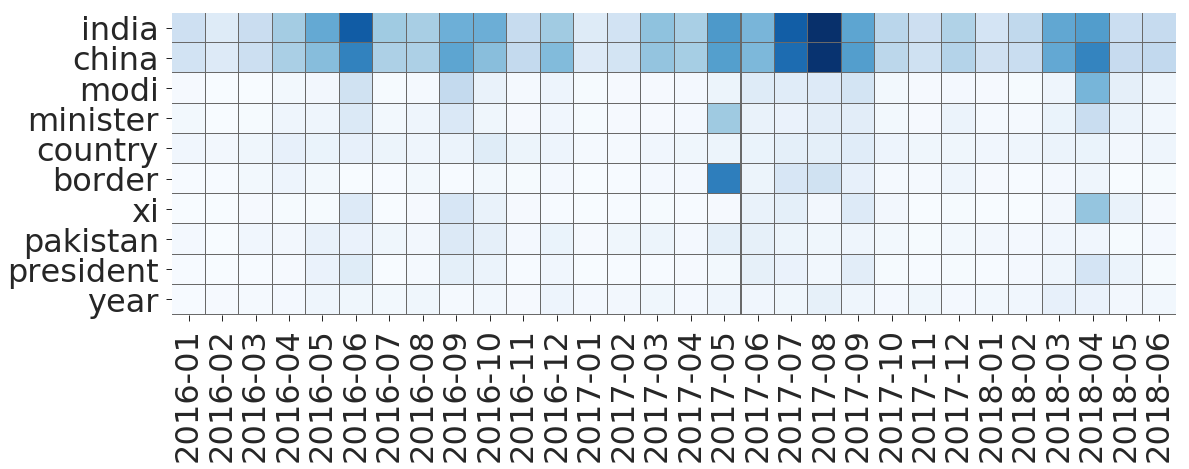

################## U.S. AND India ##################


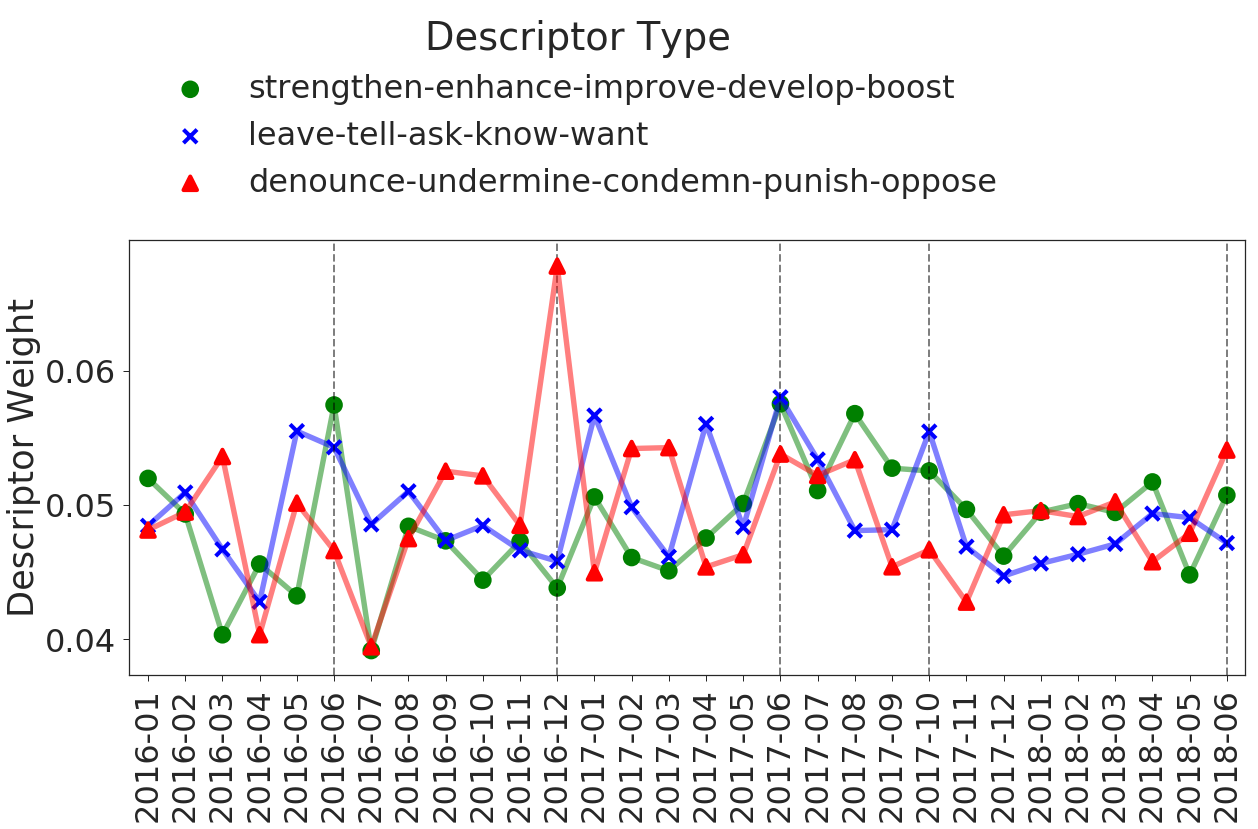

strengthen-enhance-improve-develop-boost, [0.7845]


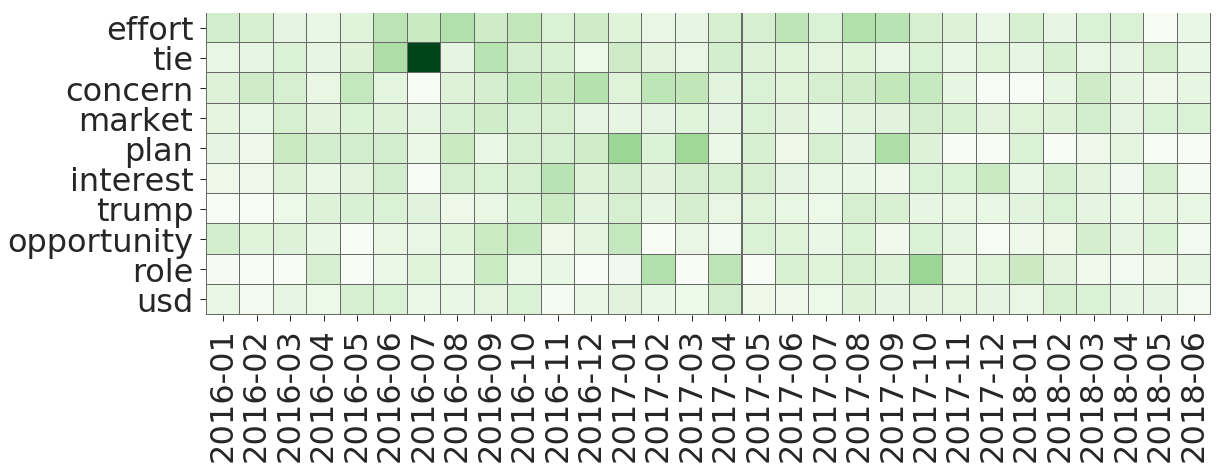

strengthen-enhance-improve-develop-boost, [0.7845] (Baseline)


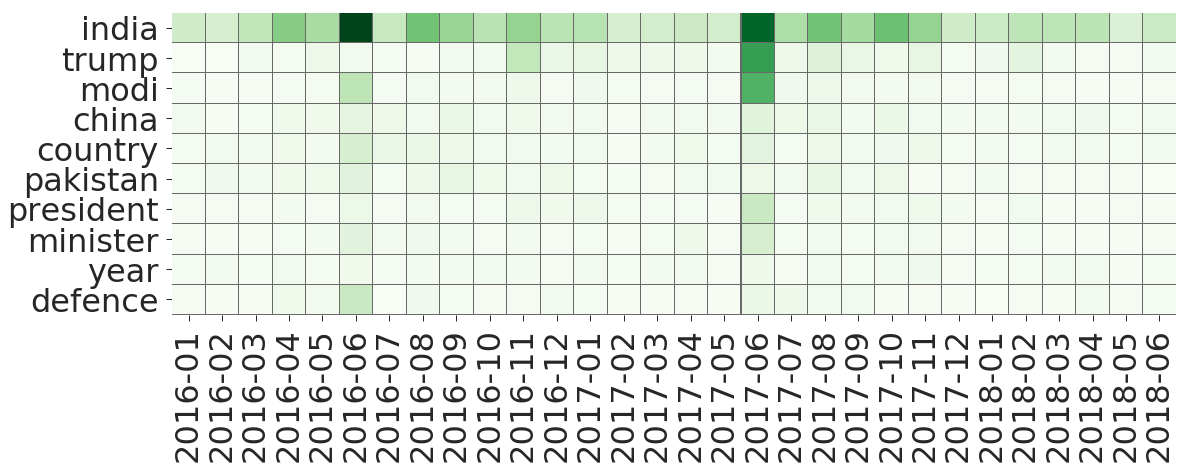

leave-tell-ask-know-want, [0.0258]


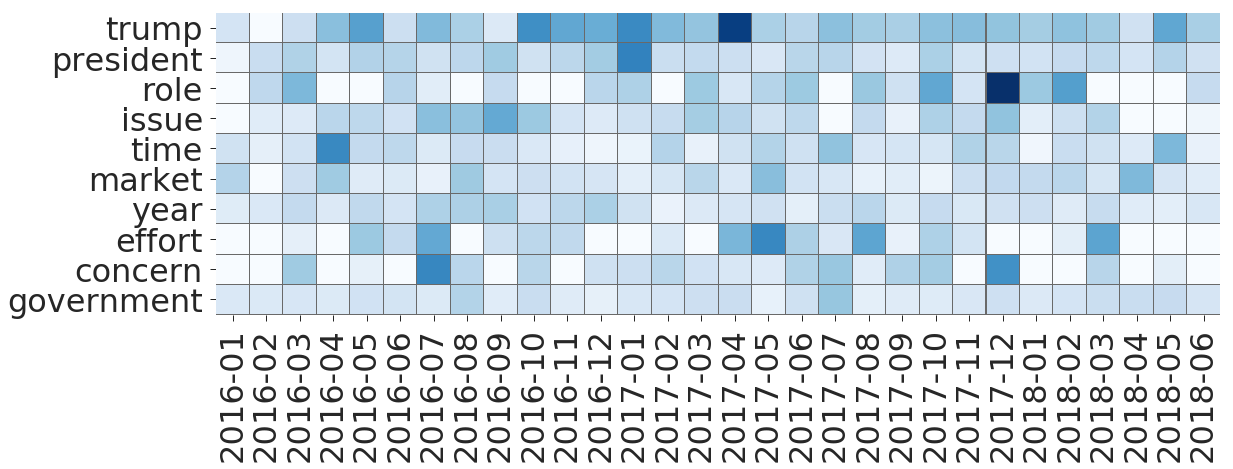

leave-tell-ask-know-want, [0.0258] (Baseline)


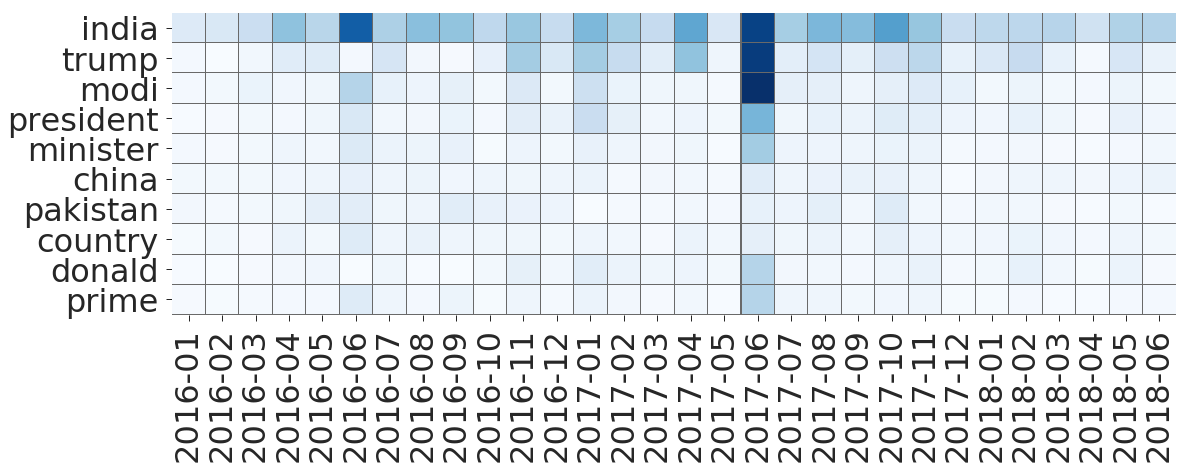

denounce-undermine-condemn-punish-oppose, [-0.8625]


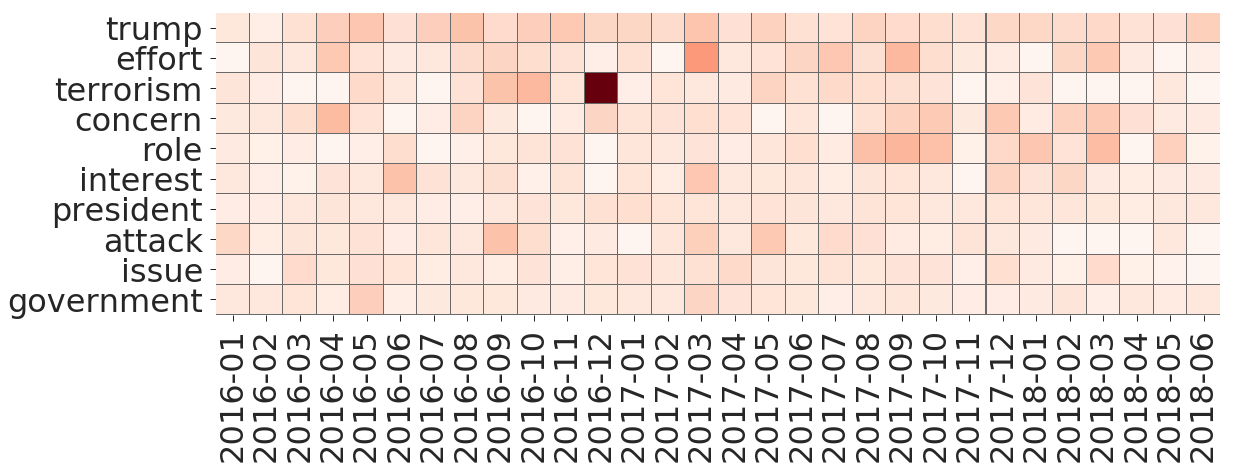

denounce-undermine-condemn-punish-oppose, [-0.8625] (Baseline)


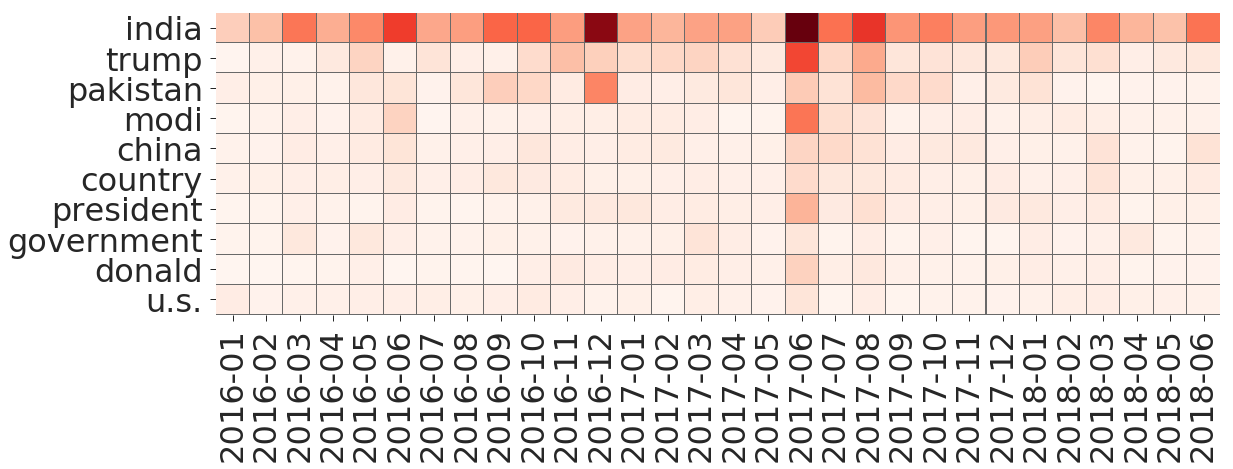

################## U.S. AND Japan ##################


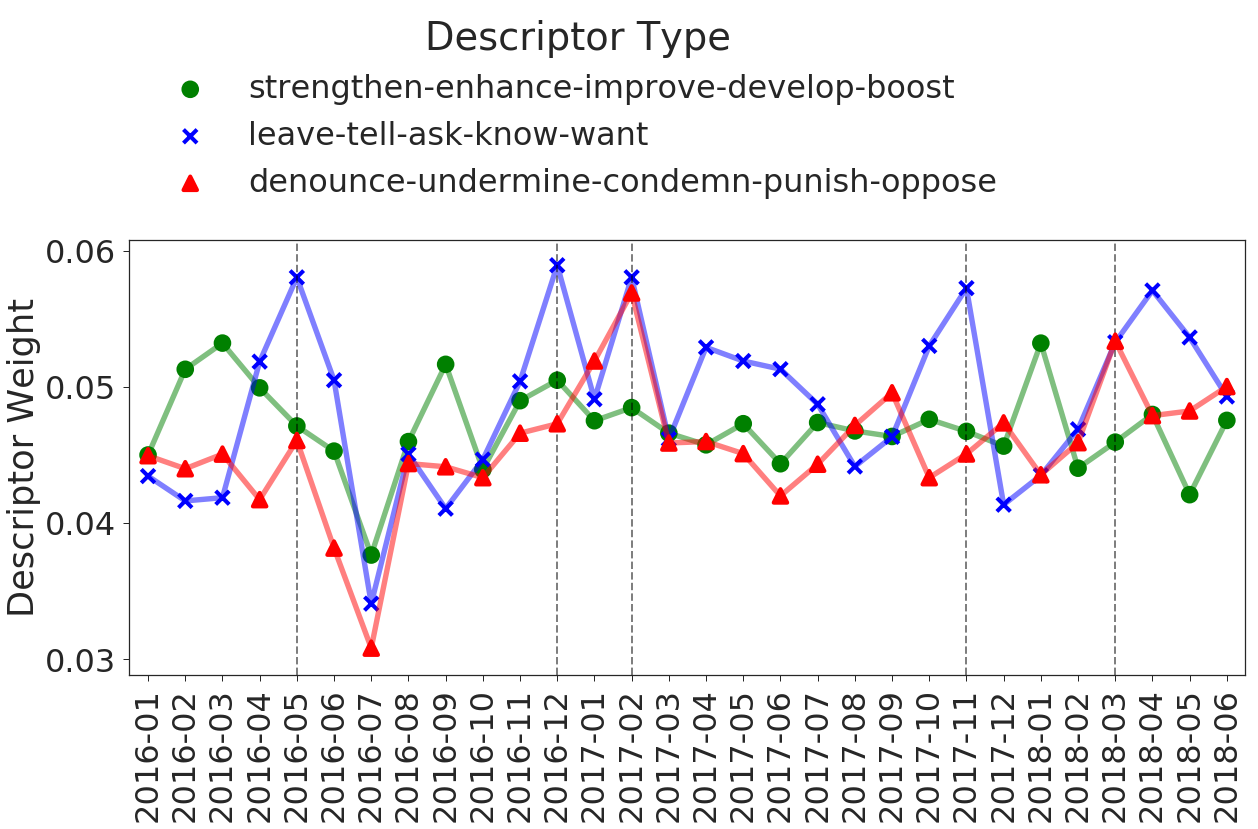

strengthen-enhance-improve-develop-boost, [0.7845]


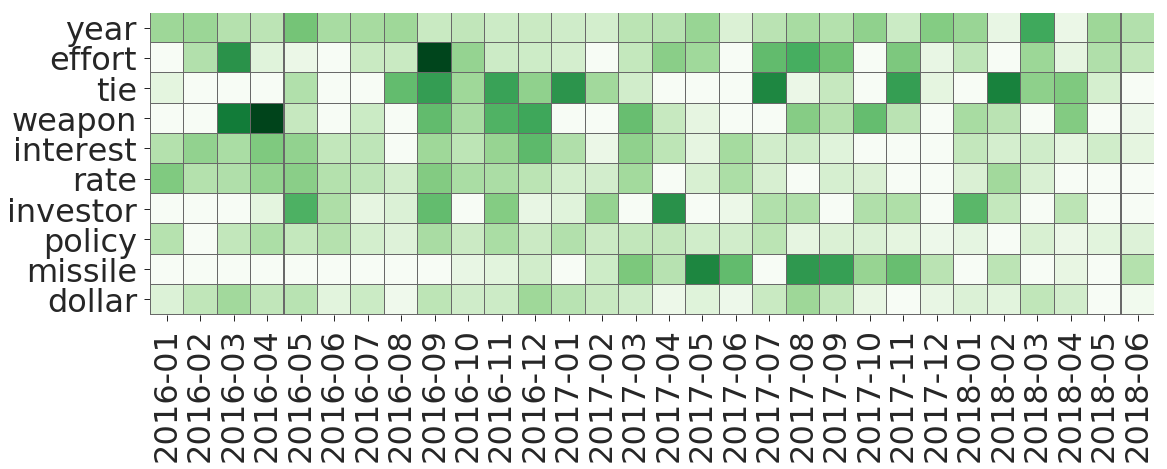

strengthen-enhance-improve-develop-boost, [0.7845] (Baseline)


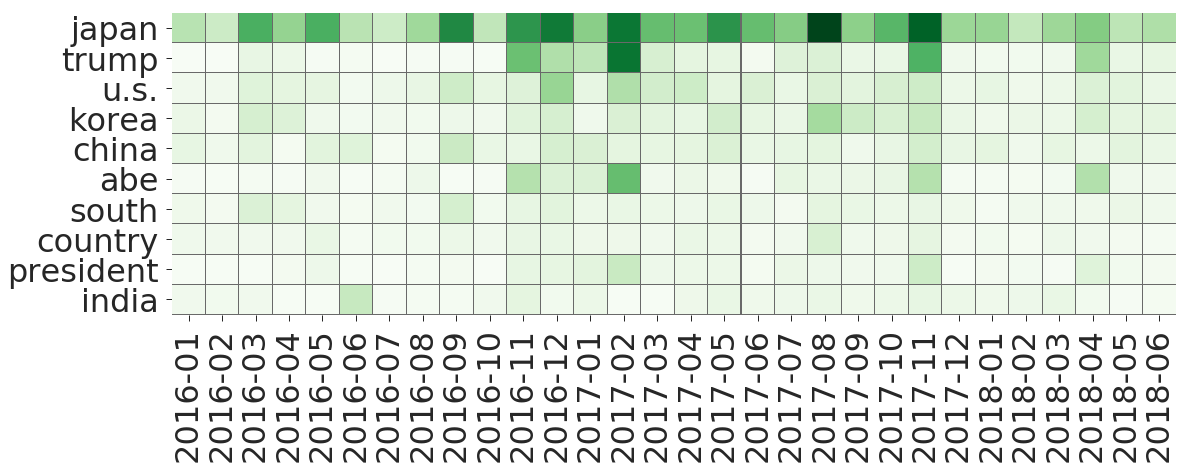

leave-tell-ask-know-want, [0.0258]


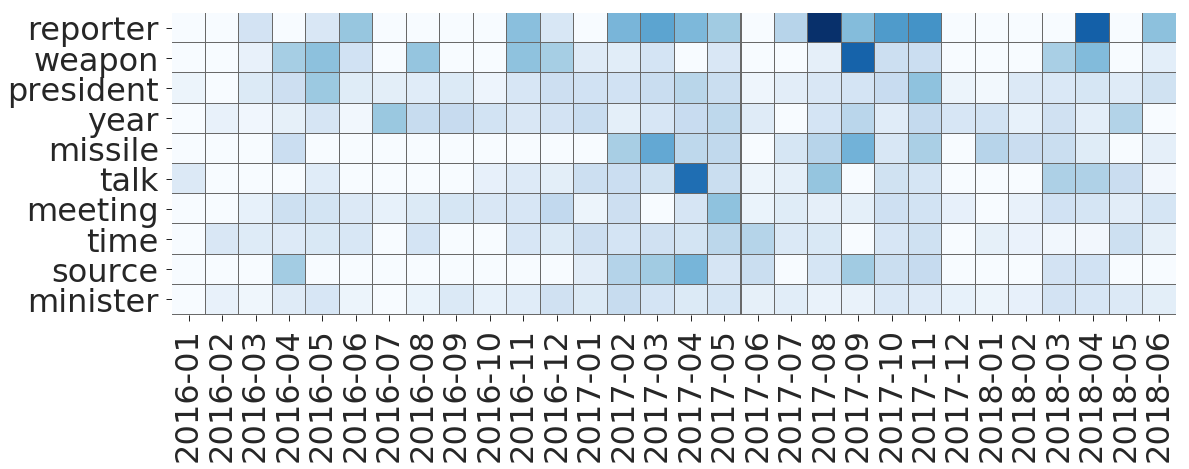

leave-tell-ask-know-want, [0.0258] (Baseline)


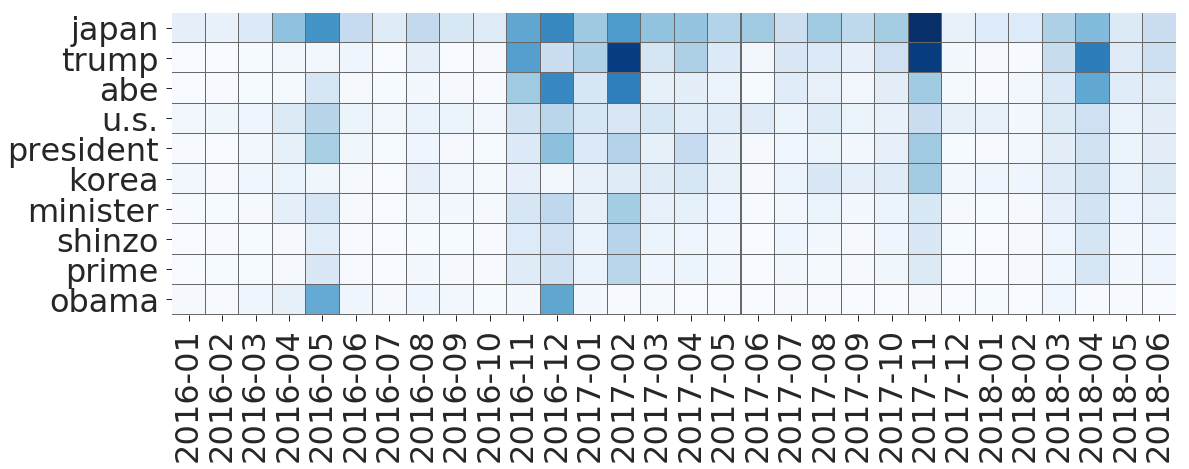

denounce-undermine-condemn-punish-oppose, [-0.8625]


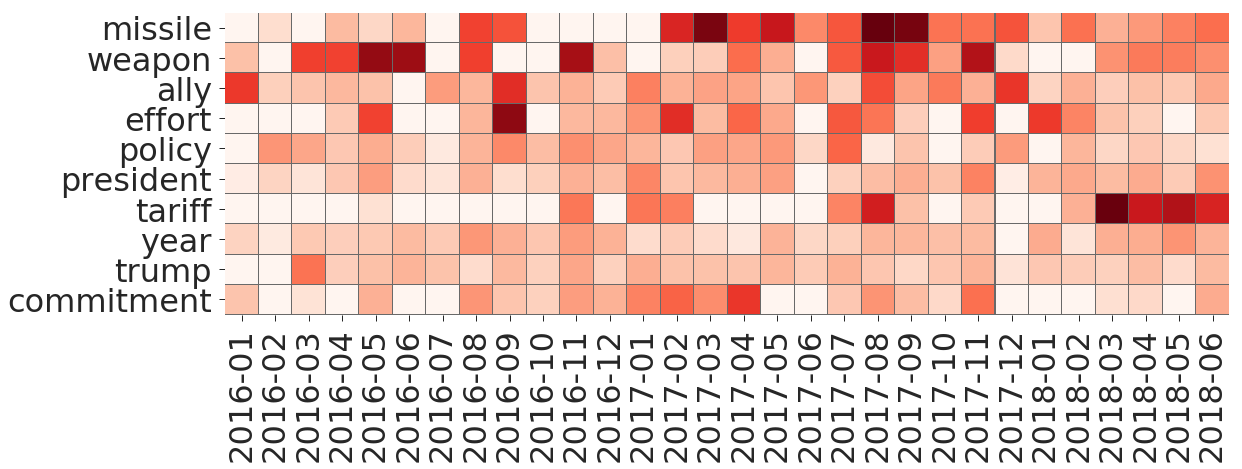

denounce-undermine-condemn-punish-oppose, [-0.8625] (Baseline)


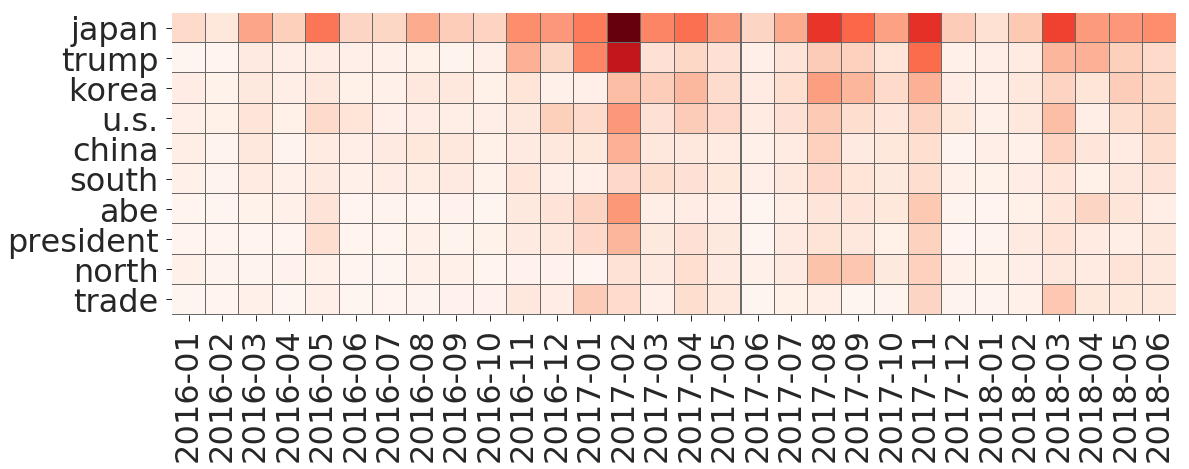

In [20]:
for rel in vis_dict.keys():
#     e2er_visualization('Internation', rel, vis_dict[rel][0], dict(), dict(),
#                        rmn_descs, desc_palette, key_event_dict)
    e2er_visualization('Internation', rel, vis_dict[rel][0], vis_dict[rel][1], vis_dict[rel][2],
                       rmn_descs, desc_palette, key_event_dict)

## For change point analysis

In [21]:
# move to a new notebook to do this
pickle.dump((vis_dict, key_event_dict), open('change_point_resource_we.pkl', 'wb'))

## Samples With High Descriptor Score
descriptor 20: denounce

descriptor 9: strengthen

In [22]:
# param: entity pair, descriptor index, month
desc_query(desc_sample_file_name, "U.S. AND China", 20, '18-03')



  China has warned US of retaliation as it threatens tariffs on $3b worth of goods PHOTO : ONLINE
The US and China 's top economic officials agreed by phone on Saturday to " continue to communicate " on trade issues , Chinese state media said , as President Donald Trump pledged his escalating trade showdown would get results despite push back from Europe and Beijing .
 In his latest jolt to the prevailing global order , Trump on Thursday authorised tariffs on as much as $60 billion of Chinese imports , targeting sectors in which Washington says China has stolen American technology .
 Liu He , the Chinese vice premier in charge of the economy , told US Treasury Secretary Steven Mnuchin on Saturday that Beijing was " ready to defend its national interests " but hoped that " both sides will remain rational and work together " , according to China 's official Xinhua news agency .
 He also accused a US probe into Chinese intellectual property practices of violating international trade rul

In [23]:
desc_query(desc_sample_file_name, "U.S. AND China", 9, '18-03')



 President Donald Trump argues that the widening US external deficit reflects unfair international rules that benefit its trade partners , with China receiving the most attention .
 To understand the current China-US trade relationship , two points should be considered .
First , until 1985 , China had a trade deficit with the US .
Then the imbalance shifted , and China registered a $60 million trade surplus with the US , which accounted for 0.3% of the total US external deficit .
In 2016 , however , the US trade deficit with China amounted to $347 billion , accounting for 44% of its total deficit .
 The increase in China 's trade surplus with the US since 1985 has been driven primarily by the evolution of the East Asian economy .
As its wage levels rose , the US began importing consumer goods from Japan ; then it shifted to importing these goods from the four " Asian tigers " -- Hong Kong , Singapore , South Korea , and Taiwan -- before finally sourcing most of these imports from Chi

## Samples With High Attention Score

In [24]:
# param: entity pair, descriptor index, month, word
attn_query(attn_sample_file_name, "U.S. AND China", 20, '17-02', "tariff") # denounce



  Trump has also threatened to impose tariffs on goods from Mexico and China . 




  The Obama administration actually slapped a 500% tariff on Chinese steel , but all that did was make life harder for manufacturers . 




 " If we go down the road of imposing tariffs on our major trading partners , including China , they will retaliate on us " and may scale back purchases of U.S. debt , he said . 




  Originally , Trump favoured the simple imposition of a tariff on products from selected countries , especially China and Mexico . 




 Trump 's policies , such as imposing tariffs on China and limiting immigration , were reported as reasons to back gold . 




## Attention score on single sample

In [25]:
tar_rel = "U.S. AND China"
tar_month = 27
tar_sample = "China says ready to defend its interests in US trade spat"

with torch.no_grad():
    for book, chars, spans, masks, months, samples in span_data:
        c1_name, c2_name = [cmap[c] for c in chars]
        b_name = bmap[book[0]]
        rel = c1_name + ' AND ' + c2_name
        
        if rel != tar_rel:
            continue
            
        char1 = [chars[0]]
        char2 = [chars[1]]
        model.zero_grad()
        model.init_attention(A_dict[(chars[0], chars[1])].to(device))
        
        # calculate attention score for each document
        for span_index, (span, mask, month, sample) in enumerate(zip(spans, masks, months, samples)):
            if month != tar_month:
                continue
                
            if tar_sample not in sample[0]:
                continue
                
            print(sample[0], '\n')
            
            candidate_set = set()
            for i in range(len(span)):
                if mask[i] == predicate_ix:
                    print(revmap[span[i]])
                if mask[i] == noun_ix:
                    candidate_set.add((span[i], month))

            if len(candidate_set) == 0:
                continue

            noun_list = []
            month_list = []
            for candidate in candidate_set:
                noun_list.append(candidate[0])
                month_list.append(candidate[1])

            noun_part_mat = model.l_noun.we(torch.LongTensor(noun_list).to(device))
            month_part_mat = torch.zeros([len(noun_part_mat), d_noun_hidden - d_word], dtype=torch.float).to(device)
            for i, month in enumerate(month_list):
                month_part_mat[i][month] = 1

            hidden_mat = torch.cat((noun_part_mat, month_part_mat), 1)

            key_mat = model.l_noun.linear_key(hidden_mat)
            key_mat = torch.tanh(key_mat)

            query_mat = model.l_noun.query(torch.LongTensor([i for i in range(1)]).to(device)) # only one q_vec

            alpha_mat = torch.mm(query_mat, torch.t(key_mat))
            alpha_mat = F.softmax(alpha_mat, dim=1)
            alpha_mat = alpha_mat.detach().cpu().numpy()
            
            alpha_row = alpha_mat[0] # only one q_vec

            print('\n', sorted([(revmap[noun_list[j]], score) for j, score in enumerate(alpha_row)], key=lambda x: -x[1]))

 China says ready to defend its interests in US trade spat
 BEIJING The United States has violated international trade rules with an inquiry into intellectual property and China is ready to defend its interests , Vice Premier Liu He told US Treasury Secretary Steven Mnuchin , state media said on Saturday .
 US President Donald Trump plans to impose tariffs on up to US$60 billion in Chinese goods for what he calls misappropriation of US intellectual property under Section 301 of the 1974 US Trade Act .
 " China has already prepared , and has the strength , to defend its national interests , " Mr Liu said , adding that China hopes both sides can work hard to protect the broad picture of generally stable Sino-US trade and business relations .
 China showed readiness to retaliate by declaring plans to levy additional duties on up to US$3 billion of US imports , including fruit and wine , in response to US import tariffs on steel and aluminium that were due to take effect on Friday .
 " We 